# Plot ensemble mean maps

In [1]:
# import things
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cftime
import regionmask
import xesmf as xe 

# this is all for plotting...
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid
from matplotlib.colors import BoundaryNorm
from matplotlib.colors import LinearSegmentedColormap
import cartopy.feature as cfeature
import matplotlib.mlab as mlab
import cartopy.io.shapereader as shapereader
from dask.diagnostics import ProgressBar
from scipy import stats
import os
import sys
sys.path.append('/Users/nickywright/repos/palaeoclimate-lastmillennium')

import gmtColormap as gmtColormap

import matplotlib as mpl
mpl.rcParams['font.sans-serif'] = 'Helvetica'
mpl.rcParams['pdf.fonttype'] = 42 # change font from Arial (used in initial submission) to Helvetica

import copy

import warnings
warnings.filterwarnings('ignore')
import climate_droughts_xr_funcs

## import files

In [2]:
input_dir = '/Volumes/LaCie/droughts_through_time/files'

In [3]:
hist_ens = xr.open_dataset('%s/historical_1900/hist_merged_regridded_aus_2deg_v2.nc' % input_dir)

In [4]:
lm_ens = xr.open_dataset('%s/lastmillennium_threshold_1900-2000/lm_merged_regridded_aus_pre1850_2deg_v2.nc' % input_dir)

In [5]:
historical_year = 1900
input_dir_hist = '%s/historical_%s' % (input_dir, historical_year)


awap_gf_annual = xr.open_dataset('%s/awap_gf_precip_hist_annual_v3.nc' % input_dir_hist)



In [6]:
cntl_ens_aus = xr.open_dataset('%s/control_v2/cntl_merged_regridded_aus_2deg.nc' % input_dir)

# calculate intensity and severity as percentages

In [7]:
def mean_intensity_severity_percentage(ds, threshold_start, threshold_end):
    ds_clim = ds.where((ds['year'] >= threshold_start) & (ds['year'] <= threshold_end), drop=True)
#     ds_clim = ds.where((ds.year >= threshold_start and ds.year < threshold_end), drop=True)
    ds['droughts_2s2e_intensity_pc'] = ds.droughts_2s2e_intensity / ds_clim.PRECT_mm.mean(dim='year')
    ds['droughts_2s2e_intensity_pc_mean'] = ds.droughts_2s2e_intensity_pc.mean(dim='year') * -100
    ds['droughts_2s2e_severity_pc'] = ds.droughts_2s2e_severity / ds_clim.PRECT_mm.mean(dim='year')
    ds['droughts_2s2e_severity_pc_mean'] = ds.droughts_2s2e_severity_pc.mean(dim='year') * -100

    ds['droughts_median_intensity_pc'] = ds.droughts_median_intensity / ds_clim.PRECT_mm.mean(dim='year')
    ds['droughts_median_intensity_pc_mean'] = ds.droughts_median_intensity_pc.mean(dim='year') * -100
    ds['droughts_median_severity_pc'] = ds.droughts_median_severity / ds_clim.PRECT_mm.mean(dim='year')
    ds['droughts_median_severity_pc_mean'] = ds.droughts_median_severity_pc.mean(dim='year') * -100
    
    ds['droughts_20perc_intensity_pc'] = ds.droughts_20perc_intensity / ds_clim.PRECT_mm.mean(dim='year')
    ds['droughts_20perc_intensity_pc_mean'] = ds.droughts_20perc_intensity_pc.mean(dim='year') * -100
    ds['droughts_20perc_severity_pc'] = ds.droughts_20perc_severity / ds_clim.PRECT_mm.mean(dim='year')
    ds['droughts_20perc_severity_pc_mean'] = ds.droughts_20perc_severity_pc.mean(dim='year') * -100
    
    ds['droughts_120pc_2med_intensity_pc'] = ds.droughts_120pc_2med_intensity / ds_clim.PRECT_mm.mean(dim='year')
    ds['droughts_120pc_2med_intensity_pc_mean'] = ds.droughts_120pc_2med_intensity_pc.mean(dim='year') * -100
    ds['droughts_120pc_2med_severity_pc'] = ds.droughts_120pc_2med_severity / ds_clim.PRECT_mm.mean(dim='year')
    ds['droughts_120pc_2med_severity_pc_mean'] = ds.droughts_120pc_2med_severity_pc.mean(dim='year') * -100
    
    ds['droughts_220pc_1med_intensity_pc'] = ds.droughts_220pc_1med_intensity / ds_clim.PRECT_mm.mean(dim='year')
    ds['droughts_220pc_1med_intensity_pc_mean'] = ds.droughts_220pc_1med_intensity_pc.mean(dim='year') * -100
    ds['droughts_220pc_1med_severity_pc'] = ds.droughts_220pc_1med_severity / ds_clim.PRECT_mm.mean(dim='year')
    ds['droughts_220pc_1med_severity_pc_mean'] = ds.droughts_220pc_1med_severity_pc.mean(dim='year') * -100

In [8]:
mean_intensity_severity_percentage(hist_ens, 1900, 2000)

In [9]:
# mean_intensity_severity_percentage(lm_ens, 1900, 2000) # no need to calculate on here because it was done when creating the ensemble means...
mean_intensity_severity_percentage(cntl_ens_aus, cntl_ens_aus.year[0], cntl_ens_aus.year[-1])

In [10]:
mean_intensity_severity_percentage(awap_gf_annual, 1900, 2000)

In [11]:
awap_gf_annual['droughts_2s2e_intensity_pc_mean'] = awap_gf_annual.droughts_2s2e_intensity_pc.mean(dim='year') * -100
awap_gf_annual['droughts_2s2e_severity_pc_mean'] = awap_gf_annual.droughts_2s2e_severity_pc.mean(dim='year') * -100

# Plot

In [12]:
import geopandas as gp

mdb = gp.read_file('/Users/nickywright/Data/Coastlines/Murray.shp')

### checking things for text

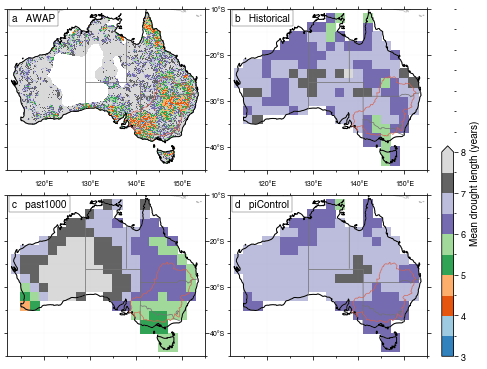

In [15]:
#checking things for the actual text - figures not saved

drought_type = 'droughts_2s2e_mean'

lons = [awap_gf_annual.lon, hist_ens.lon, lm_ens.lon, cntl_ens_aus.lon]
lats = [awap_gf_annual.lat, hist_ens.lat, lm_ens.lat, cntl_ens_aus.lat]
data = [awap_gf_annual[drought_type], hist_ens[drought_type].mean(dim='model'),
        lm_ens[drought_type].mean(dim='model'), cntl_ens_aus[drought_type].mean(dim='model')]
# cmaps = [cmap]
colorbar_label = ['Mean drought length (years)']
contour_levels = np.arange(3, 8.5, 0.5)
cmaps = plt.cm.get_cmap('tab20c')

cbar_ticks = np.arange(3,9,1)
cbar_minor_ticks = np.arange(3,12,0.5)
 
norms = [BoundaryNorm(contour_levels, ncolors=cmaps.N, clip=False)]

label_fontsize=10
tick_fontsize = 9
annot_fontsize = 7
linewidth_border = 0.75
shrink=0.81  # for colorbar

subplot_title = ['a   AWAP', 'b   Historical', 'c   past1000', 'd   piControl']
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# --- start plotting
projection = ccrs.PlateCarree()

axes_class = (GeoAxes, dict(map_projection=projection))

# ------ actually plot
fig = plt.figure(figsize=(8,6.5))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(2, 2),
                axes_pad=(0.35, 0.35), # spacing between axes. horizontal, vertical
                label_mode='',
                cbar_location='right', cbar_mode='single',
                cbar_pad=0.2, cbar_size='3%')  # note the empty label_mode

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
for i, ax in enumerate(axgr):
   
    ax.set_extent([112, 155, -43, -10])
    ax.coastlines(color='#bdbdbd', linewidth=0.75)
    ax.gridlines(linewidth=0.1, alpha=0.3)
    
    
    if i == 0 or i == 2:
        for label in ax.get_yticklabels():
            label.set_visible(False)
            
    ax.set_xticks(np.arange(120, 160, 10), crs=projection)
    lon_formatter = LongitudeFormatter()
    ax.set_xticks(np.arange(115, 160, 5), minor=True)
    ax.xaxis.set_major_formatter(lon_formatter)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(annot_fontsize)
     
    #    --- set up y ticks
    ax.set_yticks(np.arange(-40, 0, 10), crs=projection)
    ax.set_yticks(np.arange(-45,-5,5), minor=True)
    lat_formatter = LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.yaxis.set_ticks_position('both')    
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(annot_fontsize)
    
    if i < 2:
        ax.xaxis.set_ticks_position('both')
        ax.tick_params(axis='x', pad=6.5)
        
            
    if i % 2 != 0:
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(annot_fontsize)
        ax.tick_params(axis='y', pad=1)
        ax.yaxis.set_ticks_position('both')

    if i >= 2:
        ax.xaxis.set_ticks_position('both')
        for label in ax.get_xticklabels():
            label.set_visible(False)
    
    ax.xaxis.set_tick_params(width=linewidth_border, which='both')
    ax.yaxis.set_tick_params(width=linewidth_border, which='both')
        
    
    # plot Aus as black outline
    shpfilename = shapereader.natural_earth(resolution='50m',
                                      category='cultural',
                                      name='admin_0_countries')
    
    reader = shapereader.Reader(shpfilename)
    countries = reader.records()

    for country in countries:
        if country.attributes['ADM0_A3'] == 'AUS':
            ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                          edgecolor='k', facecolor='none')
    
    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
    states_provinces = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines',
                                                    scale='50m', facecolor='none')
    ax.add_feature(states_provinces, edgecolor='#737373', linewidth=0.75)  # plot state lines
    
    ax.add_geometries(mdb.geometry, crs = ccrs.PlateCarree(), edgecolor='#d6604d', facecolor='none', linewidth=0.75, alpha=0.8)  # plot state lines
    
    # plot the data!
    p = ax.pcolormesh(lons[i], lats[i], data[i], 
                  transform=ccrs.PlateCarree(), cmap=cmaps, norm=norms[0],
                      vmin=contour_levels[0], vmax=contour_levels[-1])

#     if sig != None:
#         if i <= 13:
#             df_data_sig = data_sig[i].to_dataframe()
#             df_data_sig = df_data_sig.dropna()
#             df_data_sig = df_data_sig.reset_index()
#             p2 = ax.scatter(df_data_sig.lon, df_data_sig.lat, s=2, c='k', transform=ccrs.PlateCarree())    
    
    text_x = 0.025
    text_y = 0.91
    
    title = ax.text(text_x, text_y + 0.004, subplot_title[i], transform=ax.transAxes, 
                    horizontalalignment='left', verticalalignment='bottom', 
                    fontweight='normal', fontsize=label_fontsize, color='white',
                    bbox=dict(facecolor='white', edgecolor='black', linewidth=0.3, pad=3.0))
    
    title = ax.text(text_x, text_y, subplot_title[i], transform=ax.transAxes, 
                    horizontalalignment='left', verticalalignment='bottom', 
                    fontweight='normal', fontsize=label_fontsize)

    
cbar = plt.colorbar(p, cax=axgr.cbar_axes[0], extend='max', extendfrac=0.03, ticks=cbar_ticks)
cbar.set_label(colorbar_label[0], fontsize=10)
cbar.ax.tick_params(labelsize=tick_fontsize, length=4, width=linewidth_border)
# cbar.ax.minorticks_on()
cbar.ax.yaxis.set_ticks(cbar_minor_ticks, minor=True) 
cbar.ax.tick_params(width=linewidth_border, which='minor')
# cbar.set_ticks(cbar_minor_ticks, minor=True)    



# fig.savefig('ens_%s.pdf' % drought_type, dpi=300, bbox_inches='tight')
plt.show()



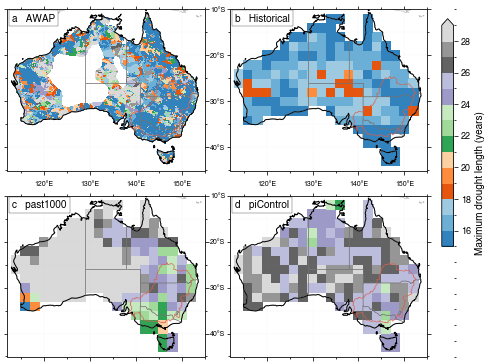

In [29]:
drought_type = 'droughts_2s2e_max'

lons = [awap_gf_annual.lon, hist_ens.lon, lm_ens.lon, cntl_ens_aus.lon]
lats = [awap_gf_annual.lat, hist_ens.lat, lm_ens.lat, cntl_ens_aus.lat]
data = [awap_gf_annual[drought_type], hist_ens[drought_type].mean(dim='model'),
        lm_ens[drought_type].mean(dim='model'), cntl_ens_aus[drought_type].mean(dim='model')]
# cmaps = [cmap]
colorbar_label = ['Maximum drought length (years)']
contour_levels = np.arange(15, 30, 1)
cmaps = plt.cm.get_cmap('tab20c')

norms = [BoundaryNorm(contour_levels, ncolors=cmaps.N, clip=False)]

cbar_ticks = np.arange(8,32,2)
cbar_minor_ticks = np.arange(8,31,1)
 
norms = [BoundaryNorm(contour_levels, ncolors=cmaps.N, clip=False)]

label_fontsize=10
tick_fontsize = 9
annot_fontsize = 7
linewidth_border = 0.75
shrink=0.81  # for colorbar

subplot_title = ['a   AWAP', 'b   Historical', 'c   past1000', 'd   piControl']
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# --- start plotting
projection = ccrs.PlateCarree()

axes_class = (GeoAxes, dict(map_projection=projection))

# ------ actually plot
fig = plt.figure(figsize=(8,6.5))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(2, 2),
                axes_pad=(0.35, 0.35), # spacing between axes. horizontal, vertical
                label_mode='',
                cbar_location='right', cbar_mode='single',
                cbar_pad=0.2, cbar_size='3%')  # note the empty label_mode

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
for i, ax in enumerate(axgr):
   
    ax.set_extent([112, 155, -43, -10])
    ax.coastlines(color='#bdbdbd', linewidth=0.75)
    ax.gridlines(linewidth=0.1, alpha=0.3)
    
    
    if i == 0 or i == 2:
        for label in ax.get_yticklabels():
            label.set_visible(False)
            
    ax.set_xticks(np.arange(120, 160, 10), crs=projection)
    lon_formatter = LongitudeFormatter()
    ax.set_xticks(np.arange(115, 160, 5), minor=True)
    ax.xaxis.set_major_formatter(lon_formatter)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(annot_fontsize)
     
    #    --- set up y ticks
    ax.set_yticks(np.arange(-40, 0, 10), crs=projection)
    ax.set_yticks(np.arange(-45,-5,5), minor=True)
    lat_formatter = LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.yaxis.set_ticks_position('both')    
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(annot_fontsize)
    
    if i < 2:
        ax.xaxis.set_ticks_position('both')
        ax.tick_params(axis='x', pad=6.5)
        
            
    if i % 2 != 0:
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(annot_fontsize)
        ax.tick_params(axis='y', pad=1)
        ax.yaxis.set_ticks_position('both')

    if i >= 2:
        ax.xaxis.set_ticks_position('both')
        for label in ax.get_xticklabels():
            label.set_visible(False)
    
    ax.xaxis.set_tick_params(width=linewidth_border, which='both')
    ax.yaxis.set_tick_params(width=linewidth_border, which='both')
        
    
    # plot Aus as black outline
    shpfilename = shapereader.natural_earth(resolution='50m',
                                      category='cultural',
                                      name='admin_0_countries')
    
    reader = shapereader.Reader(shpfilename)
    countries = reader.records()

    for country in countries:
        if country.attributes['ADM0_A3'] == 'AUS':
            ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                          edgecolor='k', facecolor='none')
    
    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
    states_provinces = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines',
                                                    scale='50m', facecolor='none')
    ax.add_feature(states_provinces, edgecolor='#737373', linewidth=0.75)  # plot state lines
    
    ax.add_geometries(mdb.geometry, crs = ccrs.PlateCarree(), edgecolor='#d6604d', facecolor='none', linewidth=0.75, alpha=0.8)  # plot state lines


    
    # plot the data!
    p = ax.pcolormesh(lons[i], lats[i], data[i], 
                  transform=ccrs.PlateCarree(), cmap=cmaps, norm=norms[0],
                      vmin=contour_levels[0], vmax=contour_levels[-1])

#     if sig != None:
#         if i <= 13:
#             df_data_sig = data_sig[i].to_dataframe()
#             df_data_sig = df_data_sig.dropna()
#             df_data_sig = df_data_sig.reset_index()
#             p2 = ax.scatter(df_data_sig.lon, df_data_sig.lat, s=2, c='k', transform=ccrs.PlateCarree())    
    
    text_x = 0.025
    text_y = 0.91
    
    title = ax.text(text_x, text_y + 0.004, subplot_title[i], transform=ax.transAxes, 
                    horizontalalignment='left', verticalalignment='bottom', 
                    fontweight='normal', fontsize=label_fontsize, color='white',
                    bbox=dict(facecolor='white', edgecolor='black', linewidth=0.3, pad=3.0))
    
    title = ax.text(text_x, text_y, subplot_title[i], transform=ax.transAxes, 
                    horizontalalignment='left', verticalalignment='bottom', 
                    fontweight='normal', fontsize=label_fontsize)

    
cbar = plt.colorbar(p, cax=axgr.cbar_axes[0], extend='max', extendfrac=0.03, ticks=cbar_ticks)
cbar.set_label(colorbar_label[0], fontsize=10)
cbar.ax.tick_params(labelsize=tick_fontsize, length=4, width=linewidth_border)
# cbar.ax.minorticks_on()
cbar.ax.yaxis.set_ticks(cbar_minor_ticks, minor=True) 
cbar.ax.tick_params(width=linewidth_border, which='minor')
# cbar.set_ticks(cbar_minor_ticks, minor=True)    

# fig.savefig('ens_%s.pdf' % drought_type, dpi=300, bbox_inches='tight')
plt.show()



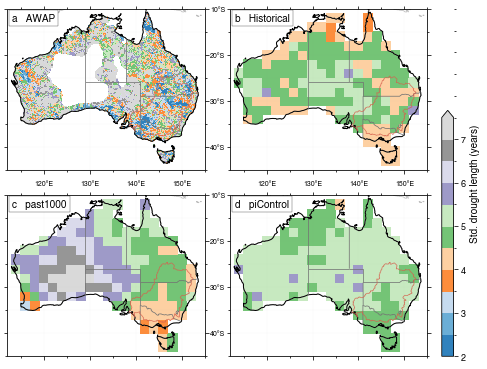

In [31]:
drought_type = 'droughts_2s2e_std'

lons = [awap_gf_annual.lon, hist_ens.lon, lm_ens.lon, cntl_ens_aus.lon]
lats = [awap_gf_annual.lat, hist_ens.lat, lm_ens.lat, cntl_ens_aus.lat]
data = [awap_gf_annual[drought_type], hist_ens[drought_type].mean(dim='model'),
        lm_ens[drought_type].mean(dim='model'), cntl_ens_aus[drought_type].mean(dim='model')]
# cmaps = [cmap]
colorbar_label = ['Std. drought length (years)']
contour_levels = np.arange(2, 8, 0.5)
cmaps = plt.cm.get_cmap('tab20c')

cbar_ticks = np.arange(2,11,1)
cbar_minor_ticks = np.arange(2,10.5,0.5)
 
norms = [BoundaryNorm(contour_levels, ncolors=cmaps.N, clip=False)]

label_fontsize=10
tick_fontsize = 9
annot_fontsize = 7
linewidth_border = 0.75
shrink=0.81  # for colorbar

subplot_title = ['a   AWAP', 'b   Historical', 'c   past1000', 'd   piControl']
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# --- start plotting
projection = ccrs.PlateCarree()

axes_class = (GeoAxes, dict(map_projection=projection))

# ------ actually plot
fig = plt.figure(figsize=(8,6.5))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(2, 2),
                axes_pad=(0.35, 0.35), # spacing between axes. horizontal, vertical
                label_mode='',
                cbar_location='right', cbar_mode='single',
                cbar_pad=0.2, cbar_size='3%')  # note the empty label_mode

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
for i, ax in enumerate(axgr):
   
    ax.set_extent([112, 155, -43, -10])
    ax.coastlines(color='#bdbdbd', linewidth=0.75)
    ax.gridlines(linewidth=0.1, alpha=0.3)
    
    
    if i == 0 or i == 2:
        for label in ax.get_yticklabels():
            label.set_visible(False)
            
    ax.set_xticks(np.arange(120, 160, 10), crs=projection)
    lon_formatter = LongitudeFormatter()
    ax.set_xticks(np.arange(115, 160, 5), minor=True)
    ax.xaxis.set_major_formatter(lon_formatter)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(annot_fontsize)
     
    #    --- set up y ticks
    ax.set_yticks(np.arange(-40, 0, 10), crs=projection)
    ax.set_yticks(np.arange(-45,-5,5), minor=True)
    lat_formatter = LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.yaxis.set_ticks_position('both')    
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(annot_fontsize)
    
    if i < 2:
        ax.xaxis.set_ticks_position('both')
        ax.tick_params(axis='x', pad=6.5)
        
            
    if i % 2 != 0:
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(annot_fontsize)
        ax.tick_params(axis='y', pad=1)
        ax.yaxis.set_ticks_position('both')

    if i >= 2:
        ax.xaxis.set_ticks_position('both')
        for label in ax.get_xticklabels():
            label.set_visible(False)
    
    ax.xaxis.set_tick_params(width=linewidth_border, which='both')
    ax.yaxis.set_tick_params(width=linewidth_border, which='both')
        
    
    # plot Aus as black outline
    shpfilename = shapereader.natural_earth(resolution='50m',
                                      category='cultural',
                                      name='admin_0_countries')
    
    reader = shapereader.Reader(shpfilename)
    countries = reader.records()

    for country in countries:
        if country.attributes['ADM0_A3'] == 'AUS':
            ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                          edgecolor='k', facecolor='none')
    
    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
    states_provinces = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines',
                                                    scale='50m', facecolor='none')
    ax.add_feature(states_provinces, edgecolor='#737373', linewidth=0.75)  # plot state lines
    
    ax.add_geometries(mdb.geometry, crs = ccrs.PlateCarree(), edgecolor='#d6604d', facecolor='none', linewidth=0.75, alpha=0.8)  # plot state lines

    
    # plot the data!
    p = ax.pcolormesh(lons[i], lats[i], data[i], 
                  transform=ccrs.PlateCarree(), cmap=cmaps, norm=norms[0],
                      vmin=contour_levels[0], vmax=contour_levels[-1])

#     if sig != None:
#         if i <= 13:
#             df_data_sig = data_sig[i].to_dataframe()
#             df_data_sig = df_data_sig.dropna()
#             df_data_sig = df_data_sig.reset_index()
#             p2 = ax.scatter(df_data_sig.lon, df_data_sig.lat, s=2, c='k', transform=ccrs.PlateCarree())    
    
    text_x = 0.025
    text_y = 0.91
    
    title = ax.text(text_x, text_y + 0.004, subplot_title[i], transform=ax.transAxes, 
                    horizontalalignment='left', verticalalignment='bottom', 
                    fontweight='normal', fontsize=label_fontsize, color='white',
                    bbox=dict(facecolor='white', edgecolor='black', linewidth=0.3, pad=3.0))
    
    title = ax.text(text_x, text_y, subplot_title[i], transform=ax.transAxes, 
                    horizontalalignment='left', verticalalignment='bottom', 
                    fontweight='normal', fontsize=label_fontsize)

    
cbar = plt.colorbar(p, cax=axgr.cbar_axes[0], extend='max', extendfrac=0.03, ticks=cbar_ticks)
cbar.set_label(colorbar_label[0], fontsize=10)
cbar.ax.tick_params(labelsize=tick_fontsize, length=4, width=linewidth_border)
# cbar.ax.minorticks_on()
cbar.ax.yaxis.set_ticks(cbar_minor_ticks, minor=True) 
cbar.ax.tick_params(width=linewidth_border, which='minor')
# cbar.set_ticks(cbar_minor_ticks, minor=True)    


# fig.savefig('ens_%s.pdf' % drought_type, dpi=300, bbox_inches='tight')
plt.show()




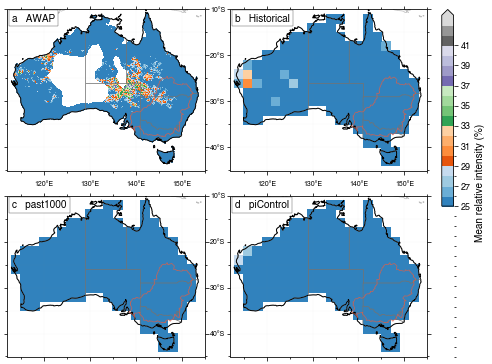

In [43]:
cpt = gmtColormap.gmtColormap('/Users/nickywright/Data/ColourPalettes/YlOrRd_09-1.cpt')
palette = LinearSegmentedColormap('my_colormap', cpt)

drought_type = 'droughts_2s2e_intensity_pc_mean'

lons = [awap_gf_annual.lon, hist_ens.lon, lm_ens.lon, cntl_ens_aus.lon]
lats = [awap_gf_annual.lat, hist_ens.lat, lm_ens.lat, cntl_ens_aus.lat]
data = [awap_gf_annual[drought_type], hist_ens[drought_type].mean(dim='model'),
        lm_ens[drought_type].mean(dim='model'), cntl_ens_aus[drought_type].mean(dim='model')]
# cmaps = [cmap]
colorbar_label = ['Mean relative intensity (%)']
contour_levels = np.arange(25, 45, 1)
cmaps = plt.cm.get_cmap('tab20c')
# cmaps = palette
cbar_ticks = np.arange(25,42,2)
cbar_minor_ticks = np.arange(10,41,1)
 
norms = [BoundaryNorm(contour_levels, ncolors=cmaps.N, clip=False)]

label_fontsize=10
tick_fontsize = 9
annot_fontsize = 7
linewidth_border = 0.75
shrink=0.81  # for colorbar

subplot_title = ['a   AWAP', 'b   Historical', 'c   past1000', 'd   piControl']
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# --- start plotting
projection = ccrs.PlateCarree()

axes_class = (GeoAxes, dict(map_projection=projection))

# ------ actually plot
fig = plt.figure(figsize=(8,6.5))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(2, 2),
                axes_pad=(0.35, 0.35), # spacing between axes. horizontal, vertical
                label_mode='',
                cbar_location='right', cbar_mode='single',
                cbar_pad=0.2, cbar_size='3%')  # note the empty label_mode

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
for i, ax in enumerate(axgr):
   
    ax.set_extent([112, 155, -43, -10])
    ax.coastlines(color='#bdbdbd', linewidth=0.75)
    ax.gridlines(linewidth=0.1, alpha=0.3)
    
    
    if i == 0 or i == 2:
        for label in ax.get_yticklabels():
            label.set_visible(False)
            
    ax.set_xticks(np.arange(120, 160, 10), crs=projection)
    lon_formatter = LongitudeFormatter()
    ax.set_xticks(np.arange(115, 160, 5), minor=True)
    ax.xaxis.set_major_formatter(lon_formatter)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(annot_fontsize)
     
    #    --- set up y ticks
    ax.set_yticks(np.arange(-40, 0, 10), crs=projection)
    ax.set_yticks(np.arange(-45,-5,5), minor=True)
    lat_formatter = LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.yaxis.set_ticks_position('both')    
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(annot_fontsize)
    
    if i < 2:
        ax.xaxis.set_ticks_position('both')
        ax.tick_params(axis='x', pad=6.5)
        
            
    if i % 2 != 0:
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(annot_fontsize )
        ax.tick_params(axis='y', pad=1)
        ax.yaxis.set_ticks_position('both')

    if i >= 2:
        ax.xaxis.set_ticks_position('both')
        for label in ax.get_xticklabels():
            label.set_visible(False)
    
    ax.xaxis.set_tick_params(width=linewidth_border, which='both')
    ax.yaxis.set_tick_params(width=linewidth_border, which='both')
        
    
    # plot Aus as black outline
    shpfilename = shapereader.natural_earth(resolution='50m',
                                      category='cultural',
                                      name='admin_0_countries')
    
    reader = shapereader.Reader(shpfilename)
    countries = reader.records()

    for country in countries:
        if country.attributes['ADM0_A3'] == 'AUS':
            ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                          edgecolor='k', facecolor='none')
    
    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
    states_provinces = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines',
                                                    scale='50m', facecolor='none')
    ax.add_feature(states_provinces, edgecolor='#737373', linewidth=0.75)  # plot state lines
    ax.add_geometries(mdb.geometry, crs = ccrs.PlateCarree(), edgecolor='#d6604d', facecolor='none', linewidth=0.75, alpha=0.8)  # plot state lines
    
    # plot the data!
    p = ax.pcolormesh(lons[i], lats[i], data[i], 
                  transform=ccrs.PlateCarree(), cmap=cmaps, norm=norms[0],
                      vmin=contour_levels[0], vmax=contour_levels[-1])

#     if sig != None:
#         if i <= 13:
#             df_data_sig = data_sig[i].to_dataframe()
#             df_data_sig = df_data_sig.dropna()
#             df_data_sig = df_data_sig.reset_index()
#             p2 = ax.scatter(df_data_sig.lon, df_data_sig.lat, s=2, c='k', transform=ccrs.PlateCarree())    
    
    text_x = 0.025
    text_y = 0.91
    
    title = ax.text(text_x, text_y + 0.004, subplot_title[i], transform=ax.transAxes, 
                    horizontalalignment='left', verticalalignment='bottom', 
                    fontweight='normal', fontsize=label_fontsize, color='white',
                    bbox=dict(facecolor='white', edgecolor='black', linewidth=0.3, pad=3.0))
    
    title = ax.text(text_x, text_y, subplot_title[i], transform=ax.transAxes, 
                    horizontalalignment='left', verticalalignment='bottom', 
                    fontweight='normal', fontsize=label_fontsize)

    
cbar = plt.colorbar(p, cax=axgr.cbar_axes[0], extend='max', extendfrac=0.03, ticks=cbar_ticks)
cbar.set_label(colorbar_label[0], fontsize=10)
cbar.ax.tick_params(labelsize=tick_fontsize, length=4, width=linewidth_border)
# cbar.ax.minorticks_on()
cbar.ax.yaxis.set_ticks(cbar_minor_ticks, minor=True) 
cbar.ax.tick_params(width=linewidth_border, which='minor')
# cbar.set_ticks(cbar_minor_ticks, minor=True)    



# fig.savefig('ens_%s.pdf' % drought_type, dpi=300, bbox_inches='tight')
plt.show()


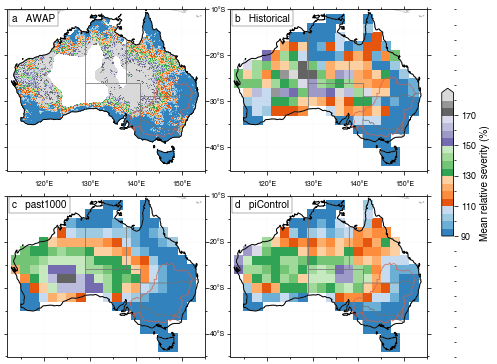

In [51]:
cpt = gmtColormap.gmtColormap('/Users/nickywright/Data/ColourPalettes/YlOrRd_09-1.cpt')
palette = LinearSegmentedColormap('my_colormap', cpt)

drought_type = 'droughts_2s2e_severity_pc_mean'

lons = [awap_gf_annual.lon, hist_ens.lon, lm_ens.lon, cntl_ens_aus.lon]
lats = [awap_gf_annual.lat, hist_ens.lat, lm_ens.lat, cntl_ens_aus.lat]
data = [awap_gf_annual[drought_type], hist_ens[drought_type].mean(dim='model'),
        lm_ens[drought_type].mean(dim='model'), cntl_ens_aus[drought_type].mean(dim='model')]
# cmaps = [cmap]
colorbar_label = ['Mean relative severity (%)']
contour_levels = np.arange(90, 190, 5)
cmaps = plt.cm.get_cmap('tab20c')
# cmaps = palette
cbar_ticks = np.arange(10,265,20)
cbar_minor_ticks = np.arange(10,250,10)
 
norms = [BoundaryNorm(contour_levels, ncolors=cmaps.N, clip=False)]

label_fontsize=10
tick_fontsize = 9
annot_fontsize = 7
linewidth_border = 0.75
shrink=0.81  # for colorbar

subplot_title = ['a   AWAP', 'b   Historical', 'c   past1000', 'd   piControl']
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# --- start plotting
projection = ccrs.PlateCarree()

axes_class = (GeoAxes, dict(map_projection=projection))

# ------ actually plot
fig = plt.figure(figsize=(8,6.5))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(2, 2),
                axes_pad=(0.35, 0.35), # spacing between axes. horizontal, vertical
                label_mode='',
                cbar_location='right', cbar_mode='single',
                cbar_pad=0.2, cbar_size='3%')  # note the empty label_mode

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
for i, ax in enumerate(axgr):
   
    ax.set_extent([112, 155, -43, -10])
    ax.coastlines(color='#bdbdbd', linewidth=0.75)
    ax.gridlines(linewidth=0.1, alpha=0.3)
    
    
    if i == 0 or i == 2:
        for label in ax.get_yticklabels():
            label.set_visible(False)
            
    ax.set_xticks(np.arange(120, 160, 10), crs=projection)
    lon_formatter = LongitudeFormatter()
    ax.set_xticks(np.arange(115, 160, 5), minor=True)
    ax.xaxis.set_major_formatter(lon_formatter)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(annot_fontsize)
     
    #    --- set up y ticks
    ax.set_yticks(np.arange(-40, 0, 10), crs=projection)
    ax.set_yticks(np.arange(-45,-5,5), minor=True)
    lat_formatter = LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.yaxis.set_ticks_position('both')    
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(annot_fontsize)
    
    if i < 2:
        ax.xaxis.set_ticks_position('both')
        ax.tick_params(axis='x', pad=6.5)
        
            
    if i % 2 != 0:
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(annot_fontsize)
        ax.tick_params(axis='y', pad=1)
        ax.yaxis.set_ticks_position('both')

    if i >= 2:
        ax.xaxis.set_ticks_position('both')
        for label in ax.get_xticklabels():
            label.set_visible(False)
    
    ax.xaxis.set_tick_params(width=linewidth_border, which='both')
    ax.yaxis.set_tick_params(width=linewidth_border, which='both')
        
    
    # plot Aus as black outline
    shpfilename = shapereader.natural_earth(resolution='50m',
                                      category='cultural',
                                      name='admin_0_countries')
    
    reader = shapereader.Reader(shpfilename)
    countries = reader.records()

    for country in countries:
        if country.attributes['ADM0_A3'] == 'AUS':
            ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                          edgecolor='k', facecolor='none')
    
    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
    states_provinces = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines',
                                                    scale='50m', facecolor='none')
    ax.add_feature(states_provinces, edgecolor='#737373', linewidth=0.75)  # plot state lines
    
    ax.add_geometries(mdb.geometry, crs = ccrs.PlateCarree(), edgecolor='#d6604d', facecolor='none', linewidth=0.75, alpha=0.8)  # plot state lines
    
    # plot the data!
    p = ax.pcolormesh(lons[i], lats[i], data[i], 
                  transform=ccrs.PlateCarree(), cmap=cmaps, norm=norms[0],
                      vmin=contour_levels[0], vmax=contour_levels[-1])

#     if sig != None:
#         if i <= 13:
#             df_data_sig = data_sig[i].to_dataframe()
#             df_data_sig = df_data_sig.dropna()
#             df_data_sig = df_data_sig.reset_index()
#             p2 = ax.scatter(df_data_sig.lon, df_data_sig.lat, s=2, c='k', transform=ccrs.PlateCarree())    
    
    text_x = 0.025
    text_y = 0.91
    
    title = ax.text(text_x, text_y + 0.004, subplot_title[i], transform=ax.transAxes, 
                    horizontalalignment='left', verticalalignment='bottom', 
                    fontweight='normal', fontsize=label_fontsize, color='white',
                    bbox=dict(facecolor='white', edgecolor='black', linewidth=0.3, pad=3.0))
    
    title = ax.text(text_x, text_y, subplot_title[i], transform=ax.transAxes, 
                    horizontalalignment='left', verticalalignment='bottom', 
                    fontweight='normal', fontsize=label_fontsize)

    
cbar = plt.colorbar(p, cax=axgr.cbar_axes[0], extend='max', extendfrac=0.03, ticks=cbar_ticks)
cbar.set_label(colorbar_label[0], fontsize=10)
cbar.ax.tick_params(labelsize=tick_fontsize, length=4, width=linewidth_border)
# cbar.ax.minorticks_on()
cbar.ax.yaxis.set_ticks(cbar_minor_ticks, minor=True) 
cbar.ax.tick_params(width=linewidth_border, which='minor')
# cbar.set_ticks(cbar_minor_ticks, minor=True)    

# fig.savefig('ens_%s.pdf' % drought_type, dpi=300, bbox_inches='tight')
plt.show()






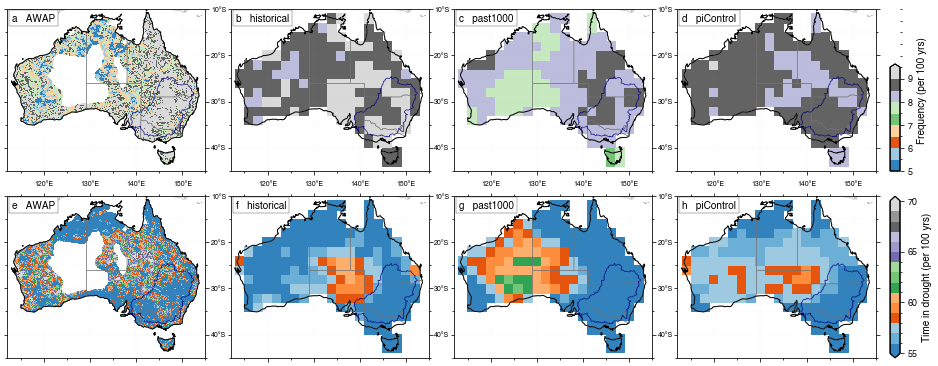

In [21]:
cpt = gmtColormap.gmtColormap('/Users/nickywright/Data/ColourPalettes/YlOrRd_09-1.cpt')
palette = LinearSegmentedColormap('my_colormap', cpt)

drought_type = 'droughts_2s2e_no_events_100yrs'
drought_type2 = 'droughts_2s2e_sum_100yrs'

lons = [awap_gf_annual_droughts_2s2e_no_events_100yrs.lon, hist_ens.lon, lm_ens.lon, cntl_ens_aus.lon, awap_gf_annual_droughts_2s2e_sum_100yrs.lon, hist_ens.lon, lm_ens.lon, cntl_ens_aus.lon]
lats = [awap_gf_annual_droughts_2s2e_no_events_100yrs.lat, hist_ens.lat, lm_ens.lat, cntl_ens_aus.lat, awap_gf_annual_droughts_2s2e_sum_100yrs.lat, hist_ens.lat, lm_ens.lat, cntl_ens_aus.lat]
data = [awap_gf_annual_droughts_2s2e_no_events_100yrs, hist_ens[drought_type].mean(dim='model'),
        lm_ens[drought_type].mean(dim='model'), cntl_ens_aus[drought_type].mean(dim='model'),
        awap_gf_annual_droughts_2s2e_sum_100yrs, hist_ens[drought_type2].mean(dim='model'),
        lm_ens[drought_type2].mean(dim='model'), cntl_ens_aus[drought_type2].mean(dim='model')]


# intensity
contour_levels1 = np.arange(5, 10, 0.5)
cmap1 = plt.cm.get_cmap('tab20c')
# cmaps = palette
cbar_ticks1 = np.arange(5,13,1)
cbar_minor_tick1 = np.arange(5,12.5,.5)


# severity cmap
# cpt = gmtColormap.gmtColormap('/Users/nickywright/Data/ColourPalettes/YlOrRd_09-1.cpt')
# palette = LinearSegmentedColormap('my_colormap', cpt)


contour_levels2 = np.arange(55, 71,1)
cbar_ticks2 = np.arange(55,80,5)
cmap2 = plt.cm.get_cmap('tab20c')
cbar_minor_tick2 = np.arange(55,65,1)
# ---
cmaps = [cmap1, cmap2]

contour_levels = [contour_levels1, contour_levels2]
norms = [BoundaryNorm(contour_levels1, ncolors=cmap1.N, clip=False), 
         BoundaryNorm(contour_levels2, ncolors=cmap2.N, clip=False)]

cbar_ticks = [cbar_ticks1, cbar_ticks2]
colorbar_label = ['Frequency (per 100 yrs)', 'Time in drought (per 100 yrs)']

cbar_extend = ['max', 'both']
cbar_minor_ticks = [cbar_minor_tick1, cbar_minor_tick2]

# ---
label_fontsize=10
tick_fontsize = 9
annot_fontsize = 7
linewidth_border = 0.75
shrink=0.81  # for colorbar

subplot_title = ['a   AWAP', 'b   historical', 'c   past1000', 'd   piControl',
                 'e   AWAP', 'f   historical', 'g   past1000', 'h   piControl']
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# --- start plotting
projection = ccrs.PlateCarree()

axes_class = (GeoAxes, dict(map_projection=projection))

# ------ actually plot
fig = plt.figure(figsize=(16,6.5))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(2, 4),
                axes_pad=(0.35, 0.35), # spacing between axes. horizontal, vertical
                label_mode='',
                cbar_location='right', cbar_mode='edge',
                cbar_pad=0.2, cbar_size='5%')  # note the empty label_mode

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
for i, ax in enumerate(axgr):
   
    ax.set_extent([112, 155, -43, -10])
    ax.coastlines(color='#bdbdbd', linewidth=0.75)
    ax.gridlines(linewidth=0.1, alpha=0.3)
    
    
    if i == 0 or i == 4:
        for label in ax.get_yticklabels():
            label.set_visible(False)
            
    ax.set_xticks(np.arange(120, 160, 10), crs=projection)
    lon_formatter = LongitudeFormatter()
    ax.set_xticks(np.arange(115, 160, 5), minor=True)
    ax.xaxis.set_major_formatter(lon_formatter)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(annot_fontsize)
     
    #    --- set up y ticks
    ax.set_yticks(np.arange(-40, 0, 10), crs=projection)
    ax.set_yticks(np.arange(-45,-5,5), minor=True)
    lat_formatter = LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.yaxis.set_ticks_position('both')    
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(annot_fontsize)
    
    if i >= 4:
        ax.xaxis.set_ticks_position('top')
        ax.tick_params(axis='x', pad=6.5)
    
    if i <= 4:
        ax.tick_params(axis='x', pad=6.5)
        
            
    if i % 4 != 0:
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(annot_fontsize )
        ax.tick_params(axis='y', pad=1)
        ax.yaxis.set_ticks_position('both')

    if i >= 4:
        ax.xaxis.set_ticks_position('both')
        for label in ax.get_xticklabels():
            label.set_visible(False)
    
    ax.xaxis.set_tick_params(width=linewidth_border, which='both')
    ax.yaxis.set_tick_params(width=linewidth_border, which='both')
        
    
    # plot Aus as black outline
    shpfilename = shapereader.natural_earth(resolution='50m',
                                      category='cultural',
                                      name='admin_0_countries')
    
    reader = shapereader.Reader(shpfilename)
    countries = reader.records()

    for country in countries:
        if country.attributes['ADM0_A3'] == 'AUS':
            ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                          edgecolor='k', facecolor='none')
    
    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
    states_provinces = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines',
                                                    scale='50m', facecolor='none')
    ax.add_feature(states_provinces, edgecolor='#737373', linewidth=0.75)  # plot state lines
    ax.add_geometries(mdb.geometry, crs = ccrs.PlateCarree(), edgecolor='navy', facecolor='none', linewidth=0.75, alpha=0.8)  # plot state lines
    
    # plot the data!
    p = ax.pcolormesh(lons[i], lats[i], data[i], 
                  transform=ccrs.PlateCarree(), cmap=cmaps[i//4], norm=norms[i//4],
                      vmin=contour_levels[i//4][0], vmax=contour_levels[i//4][-1])

#     if sig != None:
#         if i <= 13:
#             df_data_sig = data_sig[i].to_dataframe()
#             df_data_sig = df_data_sig.dropna()
#             df_data_sig = df_data_sig.reset_index()
#             p2 = ax.scatter(df_data_sig.lon, df_data_sig.lat, s=2, c='k', transform=ccrs.PlateCarree())    
    
    text_x = 0.025
    text_y = 0.91
    
    title = ax.text(text_x, text_y + 0.004, subplot_title[i], transform=ax.transAxes, 
                    horizontalalignment='left', verticalalignment='bottom', 
                    fontweight='normal', fontsize=label_fontsize, color='white',
                    bbox=dict(facecolor='white', edgecolor='black', linewidth=0.3, pad=3.0))
    
    title = ax.text(text_x, text_y, subplot_title[i], transform=ax.transAxes, 
                    horizontalalignment='left', verticalalignment='bottom', 
                    fontweight='normal', fontsize=label_fontsize)


    if i % 4:
        cbar = plt.colorbar(p, cax=axgr.cbar_axes[i//4], extend=cbar_extend[i//4], extendfrac=0.03, ticks=cbar_ticks[i//4])
        cbar.set_label(colorbar_label[i//4], fontsize=10)
        cbar.ax.tick_params(labelsize=tick_fontsize, length=4, width=0.75)
        # cbar.ax.minorticks_on()
        cbar.ax.yaxis.set_ticks(cbar_minor_ticks[i//4], minor=True) 
        cbar.ax.tick_params(width=linewidth_border, which='minor')
        # cbar.set_ticks(cbar_minor_ticks, minor=True)    


# fig.savefig('ens_%s_%s.pdf' % (drought_type, drought_type2), dpi=300, bbox_inches='tight')
plt.show()


----
### mean

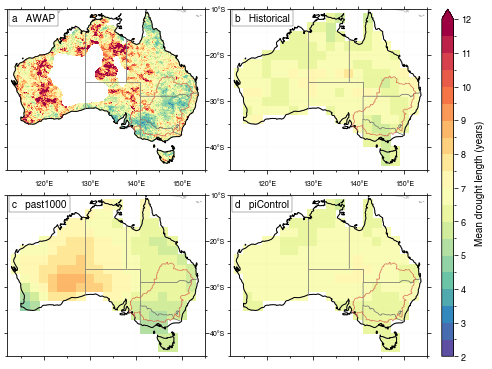

In [22]:
drought_type = 'droughts_2s2e_mean'

lons = [awap_gf_annual.lon, hist_ens.lon, lm_ens.lon, cntl_ens_aus.lon]
lats = [awap_gf_annual.lat, hist_ens.lat, lm_ens.lat, cntl_ens_aus.lat]
data = [awap_gf_annual[drought_type], hist_ens[drought_type].mean(dim='model'),
        lm_ens[drought_type].mean(dim='model'), cntl_ens_aus[drought_type].mean(dim='model')]
# cmaps = [cmap]
colorbar_label = ['Mean drought length (years)']
contour_levels = np.arange(2, 12.5, 0.5)
cmaps = plt.cm.get_cmap('Spectral_r')

cbar_ticks = np.arange(2,13,1)
cbar_minor_ticks = np.arange(2,12,0.5)
 
norms = [BoundaryNorm(contour_levels, ncolors=cmaps.N, clip=False)]

label_fontsize=10
tick_fontsize = 9
annot_fontsize = 7
linewidth_border = 0.75
shrink=0.81  # for colorbar

subplot_title = ['a   AWAP', 'b   Historical', 'c   past1000', 'd   piControl']
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# --- start plotting
projection = ccrs.PlateCarree()

axes_class = (GeoAxes, dict(map_projection=projection))

# ------ actually plot
fig = plt.figure(figsize=(8,6.5))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(2, 2),
                axes_pad=(0.35, 0.35), # spacing between axes. horizontal, vertical
                label_mode='',
                cbar_location='right', cbar_mode='single',
                cbar_pad=0.2, cbar_size='3%')  # note the empty label_mode

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
for i, ax in enumerate(axgr):
   
    ax.set_extent([112, 155, -43, -10])
    ax.coastlines(color='#bdbdbd', linewidth=0.75)
    ax.gridlines(linewidth=0.1, alpha=0.3)
    
    
    if i == 0 or i == 2:
        for label in ax.get_yticklabels():
            label.set_visible(False)
            
    ax.set_xticks(np.arange(120, 160, 10), crs=projection)
    lon_formatter = LongitudeFormatter()
    ax.set_xticks(np.arange(115, 160, 5), minor=True)
    ax.xaxis.set_major_formatter(lon_formatter)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(annot_fontsize)
     
    #    --- set up y ticks
    ax.set_yticks(np.arange(-40, 0, 10), crs=projection)
    ax.set_yticks(np.arange(-45,-5,5), minor=True)
    lat_formatter = LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.yaxis.set_ticks_position('both')    
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(annot_fontsize)
    
    if i < 2:
        ax.xaxis.set_ticks_position('both')
        ax.tick_params(axis='x', pad=6.5)
        
            
    if i % 2 != 0:
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(annot_fontsize)
        ax.tick_params(axis='y', pad=1)
        ax.yaxis.set_ticks_position('both')

    if i >= 2:
        ax.xaxis.set_ticks_position('both')
        for label in ax.get_xticklabels():
            label.set_visible(False)
    
    ax.xaxis.set_tick_params(width=linewidth_border, which='both')
    ax.yaxis.set_tick_params(width=linewidth_border, which='both')
        
    
    # plot Aus as black outline
    shpfilename = shapereader.natural_earth(resolution='50m',
                                      category='cultural',
                                      name='admin_0_countries')
    
    reader = shapereader.Reader(shpfilename)
    countries = reader.records()

    for country in countries:
        if country.attributes['ADM0_A3'] == 'AUS':
            ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                          edgecolor='k', facecolor='none')
    
    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
    states_provinces = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines',
                                                    scale='50m', facecolor='none')
    ax.add_feature(states_provinces, edgecolor='#737373', linewidth=0.75)  # plot state lines
    
    ax.add_geometries(mdb.geometry, crs = ccrs.PlateCarree(), edgecolor='#d6604d', facecolor='none', linewidth=0.75, alpha=0.8)  # plot state lines
    
    # plot the data!
    p = ax.pcolormesh(lons[i], lats[i], data[i], 
                  transform=ccrs.PlateCarree(), cmap=cmaps, norm=norms[0],
                      vmin=contour_levels[0], vmax=contour_levels[-1])

#     if sig != None:
#         if i <= 13:
#             df_data_sig = data_sig[i].to_dataframe()
#             df_data_sig = df_data_sig.dropna()
#             df_data_sig = df_data_sig.reset_index()
#             p2 = ax.scatter(df_data_sig.lon, df_data_sig.lat, s=2, c='k', transform=ccrs.PlateCarree())    
    
    text_x = 0.025
    text_y = 0.91
    
    title = ax.text(text_x, text_y + 0.004, subplot_title[i], transform=ax.transAxes, 
                    horizontalalignment='left', verticalalignment='bottom', 
                    fontweight='normal', fontsize=label_fontsize, color='white',
                    bbox=dict(facecolor='white', edgecolor='black', linewidth=0.3, pad=3.0))
    
    title = ax.text(text_x, text_y, subplot_title[i], transform=ax.transAxes, 
                    horizontalalignment='left', verticalalignment='bottom', 
                    fontweight='normal', fontsize=label_fontsize)

    
cbar = plt.colorbar(p, cax=axgr.cbar_axes[0], extend='max', extendfrac=0.03, ticks=cbar_ticks)
cbar.set_label(colorbar_label[0], fontsize=10)
cbar.ax.tick_params(labelsize=tick_fontsize, length=4, width=linewidth_border)
# cbar.ax.minorticks_on()
cbar.ax.yaxis.set_ticks(cbar_minor_ticks, minor=True) 
cbar.ax.tick_params(width=linewidth_border, which='minor')
# cbar.set_ticks(cbar_minor_ticks, minor=True)    



fig.savefig('ens_%s.pdf' % drought_type, dpi=300, bbox_inches='tight')
plt.show()


### max

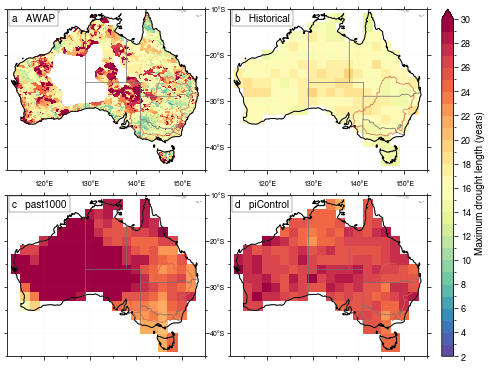

In [23]:
drought_type = 'droughts_2s2e_max'

lons = [awap_gf_annual.lon, hist_ens.lon, lm_ens.lon, cntl_ens_aus.lon]
lats = [awap_gf_annual.lat, hist_ens.lat, lm_ens.lat, cntl_ens_aus.lat]
data = [awap_gf_annual[drought_type], hist_ens[drought_type].mean(dim='model'),
        lm_ens[drought_type].mean(dim='model'), cntl_ens_aus[drought_type].mean(dim='model')]
# cmaps = [cmap]
colorbar_label = ['Maximum drought length (years)']
contour_levels = np.arange(2, 31, 1)
cmaps = plt.cm.get_cmap('Spectral_r')

norms = [BoundaryNorm(contour_levels, ncolors=cmaps.N, clip=False)]

cbar_ticks = np.arange(2,32,2)
cbar_minor_ticks = np.arange(2,31,1)
 
norms = [BoundaryNorm(contour_levels, ncolors=cmaps.N, clip=False)]

label_fontsize=10
tick_fontsize = 9
annot_fontsize = 7
linewidth_border = 0.75
shrink=0.81  # for colorbar

subplot_title = ['a   AWAP', 'b   Historical', 'c   past1000', 'd   piControl']
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# --- start plotting
projection = ccrs.PlateCarree()

axes_class = (GeoAxes, dict(map_projection=projection))

# ------ actually plot
fig = plt.figure(figsize=(8,6.5))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(2, 2),
                axes_pad=(0.35, 0.35), # spacing between axes. horizontal, vertical
                label_mode='',
                cbar_location='right', cbar_mode='single',
                cbar_pad=0.2, cbar_size='3%')  # note the empty label_mode

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
for i, ax in enumerate(axgr):
   
    ax.set_extent([112, 155, -43, -10])
    ax.coastlines(color='#bdbdbd', linewidth=0.75)
    ax.gridlines(linewidth=0.1, alpha=0.3)
    
    
    if i == 0 or i == 2:
        for label in ax.get_yticklabels():
            label.set_visible(False)
            
    ax.set_xticks(np.arange(120, 160, 10), crs=projection)
    lon_formatter = LongitudeFormatter()
    ax.set_xticks(np.arange(115, 160, 5), minor=True)
    ax.xaxis.set_major_formatter(lon_formatter)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(annot_fontsize)
     
    #    --- set up y ticks
    ax.set_yticks(np.arange(-40, 0, 10), crs=projection)
    ax.set_yticks(np.arange(-45,-5,5), minor=True)
    lat_formatter = LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.yaxis.set_ticks_position('both')    
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(annot_fontsize)
    
    if i < 2:
        ax.xaxis.set_ticks_position('both')
        ax.tick_params(axis='x', pad=6.5)
        
            
    if i % 2 != 0:
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(annot_fontsize)
        ax.tick_params(axis='y', pad=1)
        ax.yaxis.set_ticks_position('both')

    if i >= 2:
        ax.xaxis.set_ticks_position('both')
        for label in ax.get_xticklabels():
            label.set_visible(False)
    
    ax.xaxis.set_tick_params(width=linewidth_border, which='both')
    ax.yaxis.set_tick_params(width=linewidth_border, which='both')
        
    
    # plot Aus as black outline
    shpfilename = shapereader.natural_earth(resolution='50m',
                                      category='cultural',
                                      name='admin_0_countries')
    
    reader = shapereader.Reader(shpfilename)
    countries = reader.records()

    for country in countries:
        if country.attributes['ADM0_A3'] == 'AUS':
            ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                          edgecolor='k', facecolor='none')
    
    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
    states_provinces = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines',
                                                    scale='50m', facecolor='none')
    ax.add_feature(states_provinces, edgecolor='#737373', linewidth=0.75)  # plot state lines
    
    ax.add_geometries(mdb.geometry, crs = ccrs.PlateCarree(), edgecolor='#d6604d', facecolor='none', linewidth=0.75, alpha=0.8)  # plot state lines


    
    # plot the data!
    p = ax.pcolormesh(lons[i], lats[i], data[i], 
                  transform=ccrs.PlateCarree(), cmap=cmaps, norm=norms[0],
                      vmin=contour_levels[0], vmax=contour_levels[-1])

#     if sig != None:
#         if i <= 13:
#             df_data_sig = data_sig[i].to_dataframe()
#             df_data_sig = df_data_sig.dropna()
#             df_data_sig = df_data_sig.reset_index()
#             p2 = ax.scatter(df_data_sig.lon, df_data_sig.lat, s=2, c='k', transform=ccrs.PlateCarree())    
    
    text_x = 0.025
    text_y = 0.91
    
    title = ax.text(text_x, text_y + 0.004, subplot_title[i], transform=ax.transAxes, 
                    horizontalalignment='left', verticalalignment='bottom', 
                    fontweight='normal', fontsize=label_fontsize, color='white',
                    bbox=dict(facecolor='white', edgecolor='black', linewidth=0.3, pad=3.0))
    
    title = ax.text(text_x, text_y, subplot_title[i], transform=ax.transAxes, 
                    horizontalalignment='left', verticalalignment='bottom', 
                    fontweight='normal', fontsize=label_fontsize)

    
cbar = plt.colorbar(p, cax=axgr.cbar_axes[0], extend='max', extendfrac=0.03, ticks=cbar_ticks)
cbar.set_label(colorbar_label[0], fontsize=10)
cbar.ax.tick_params(labelsize=tick_fontsize, length=4, width=linewidth_border)
# cbar.ax.minorticks_on()
cbar.ax.yaxis.set_ticks(cbar_minor_ticks, minor=True) 
cbar.ax.tick_params(width=linewidth_border, which='minor')
# cbar.set_ticks(cbar_minor_ticks, minor=True)    



fig.savefig('ens_%s.pdf' % drought_type, dpi=300, bbox_inches='tight')
plt.show()


### std

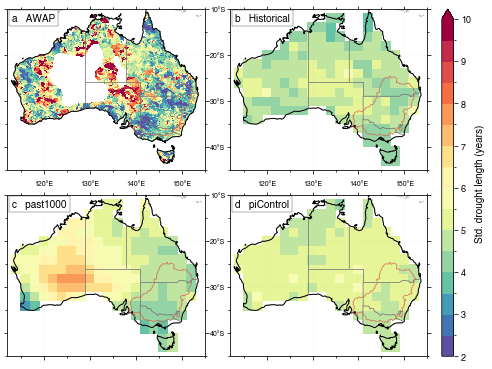

In [24]:
drought_type = 'droughts_2s2e_std'

lons = [awap_gf_annual.lon, hist_ens.lon, lm_ens.lon, cntl_ens_aus.lon]
lats = [awap_gf_annual.lat, hist_ens.lat, lm_ens.lat, cntl_ens_aus.lat]
data = [awap_gf_annual[drought_type], hist_ens[drought_type].mean(dim='model'),
        lm_ens[drought_type].mean(dim='model'), cntl_ens_aus[drought_type].mean(dim='model')]
# cmaps = [cmap]
colorbar_label = ['Std. drought length (years)']
contour_levels = np.arange(2, 10.5, 0.5)
cmaps = plt.cm.get_cmap('Spectral_r')

cbar_ticks = np.arange(2,11,1)
cbar_minor_ticks = np.arange(2,10.5,0.5)
 
norms = [BoundaryNorm(contour_levels, ncolors=cmaps.N, clip=False)]

label_fontsize=10
tick_fontsize = 9
annot_fontsize = 7
linewidth_border = 0.75
shrink=0.81  # for colorbar

subplot_title = ['a   AWAP', 'b   Historical', 'c   past1000', 'd   piControl']
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# --- start plotting
projection = ccrs.PlateCarree()

axes_class = (GeoAxes, dict(map_projection=projection))

# ------ actually plot
fig = plt.figure(figsize=(8,6.5))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(2, 2),
                axes_pad=(0.35, 0.35), # spacing between axes. horizontal, vertical
                label_mode='',
                cbar_location='right', cbar_mode='single',
                cbar_pad=0.2, cbar_size='3%')  # note the empty label_mode

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
for i, ax in enumerate(axgr):
   
    ax.set_extent([112, 155, -43, -10])
    ax.coastlines(color='#bdbdbd', linewidth=0.75)
    ax.gridlines(linewidth=0.1, alpha=0.3)
    
    
    if i == 0 or i == 2:
        for label in ax.get_yticklabels():
            label.set_visible(False)
            
    ax.set_xticks(np.arange(120, 160, 10), crs=projection)
    lon_formatter = LongitudeFormatter()
    ax.set_xticks(np.arange(115, 160, 5), minor=True)
    ax.xaxis.set_major_formatter(lon_formatter)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(annot_fontsize)
     
    #    --- set up y ticks
    ax.set_yticks(np.arange(-40, 0, 10), crs=projection)
    ax.set_yticks(np.arange(-45,-5,5), minor=True)
    lat_formatter = LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.yaxis.set_ticks_position('both')    
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(annot_fontsize)
    
    if i < 2:
        ax.xaxis.set_ticks_position('both')
        ax.tick_params(axis='x', pad=6.5)
        
            
    if i % 2 != 0:
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(annot_fontsize)
        ax.tick_params(axis='y', pad=1)
        ax.yaxis.set_ticks_position('both')

    if i >= 2:
        ax.xaxis.set_ticks_position('both')
        for label in ax.get_xticklabels():
            label.set_visible(False)
    
    ax.xaxis.set_tick_params(width=linewidth_border, which='both')
    ax.yaxis.set_tick_params(width=linewidth_border, which='both')
        
    
    # plot Aus as black outline
    shpfilename = shapereader.natural_earth(resolution='50m',
                                      category='cultural',
                                      name='admin_0_countries')
    
    reader = shapereader.Reader(shpfilename)
    countries = reader.records()

    for country in countries:
        if country.attributes['ADM0_A3'] == 'AUS':
            ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                          edgecolor='k', facecolor='none')
    
    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
    states_provinces = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines',
                                                    scale='50m', facecolor='none')
    ax.add_feature(states_provinces, edgecolor='#737373', linewidth=0.75)  # plot state lines
    
    ax.add_geometries(mdb.geometry, crs = ccrs.PlateCarree(), edgecolor='#d6604d', facecolor='none', linewidth=0.75, alpha=0.8)  # plot state lines

    
    # plot the data!
    p = ax.pcolormesh(lons[i], lats[i], data[i], 
                  transform=ccrs.PlateCarree(), cmap=cmaps, norm=norms[0],
                      vmin=contour_levels[0], vmax=contour_levels[-1])

#     if sig != None:
#         if i <= 13:
#             df_data_sig = data_sig[i].to_dataframe()
#             df_data_sig = df_data_sig.dropna()
#             df_data_sig = df_data_sig.reset_index()
#             p2 = ax.scatter(df_data_sig.lon, df_data_sig.lat, s=2, c='k', transform=ccrs.PlateCarree())    
    
    text_x = 0.025
    text_y = 0.91
    
    title = ax.text(text_x, text_y + 0.004, subplot_title[i], transform=ax.transAxes, 
                    horizontalalignment='left', verticalalignment='bottom', 
                    fontweight='normal', fontsize=label_fontsize, color='white',
                    bbox=dict(facecolor='white', edgecolor='black', linewidth=0.3, pad=3.0))
    
    title = ax.text(text_x, text_y, subplot_title[i], transform=ax.transAxes, 
                    horizontalalignment='left', verticalalignment='bottom', 
                    fontweight='normal', fontsize=label_fontsize)

    
cbar = plt.colorbar(p, cax=axgr.cbar_axes[0], extend='max', extendfrac=0.03, ticks=cbar_ticks)
cbar.set_label(colorbar_label[0], fontsize=10)
cbar.ax.tick_params(labelsize=tick_fontsize, length=4, width=linewidth_border)
# cbar.ax.minorticks_on()
cbar.ax.yaxis.set_ticks(cbar_minor_ticks, minor=True) 
cbar.ax.tick_params(width=linewidth_border, which='minor')
# cbar.set_ticks(cbar_minor_ticks, minor=True)    



fig.savefig('ens_%s.pdf' % drought_type, dpi=300, bbox_inches='tight')
plt.show()



### mean + max + std

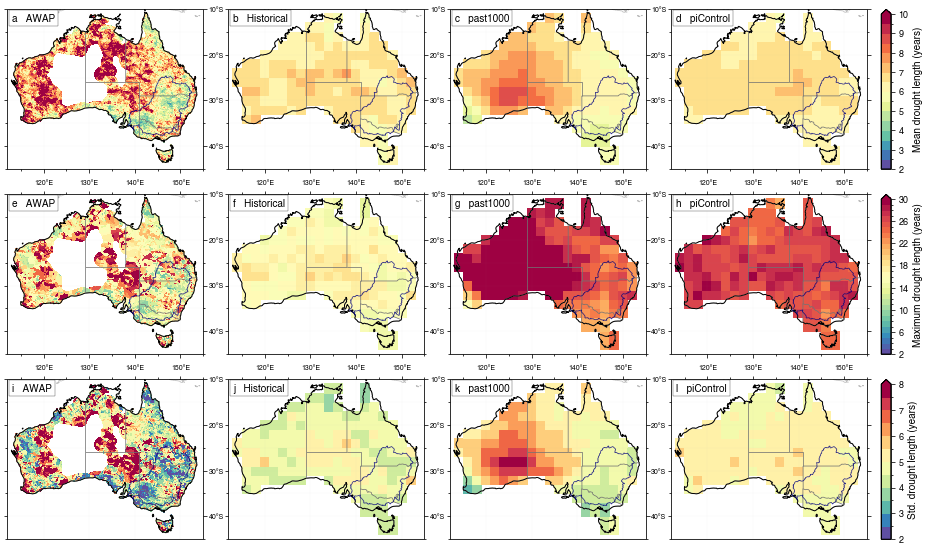

In [23]:
cpt = gmtColormap.gmtColormap('/Users/nickywright/Data/ColourPalettes/YlOrRd_09-1.cpt')
palette = LinearSegmentedColormap('my_colormap', cpt)

drought_type = 'droughts_2s2e_mean'
drought_type2 = 'droughts_2s2e_max'
drought_type3 = 'droughts_2s2e_std'

lons = [awap_gf_annual.lon, hist_ens.lon, lm_ens.lon, cntl_ens_aus.lon, awap_gf_annual.lon, hist_ens.lon, lm_ens.lon, cntl_ens_aus.lon, awap_gf_annual.lon, hist_ens.lon, lm_ens.lon, cntl_ens_aus.lon]
lats = [awap_gf_annual.lat, hist_ens.lat, lm_ens.lat, cntl_ens_aus.lat, awap_gf_annual.lat, hist_ens.lat, lm_ens.lat, cntl_ens_aus.lat, awap_gf_annual.lat, hist_ens.lat, lm_ens.lat, cntl_ens_aus.lat]
data = [awap_gf_annual[drought_type], hist_ens[drought_type].mean(dim='model'),
        lm_ens[drought_type].mean(dim='model'), cntl_ens_aus[drought_type].mean(dim='model'),
        awap_gf_annual[drought_type2], hist_ens[drought_type2].mean(dim='model'),
        lm_ens[drought_type2].mean(dim='model'), cntl_ens_aus[drought_type2].mean(dim='model'),
        awap_gf_annual[drought_type3], hist_ens[drought_type3].mean(dim='model'),
        lm_ens[drought_type3].mean(dim='model'), cntl_ens_aus[drought_type3].mean(dim='model')]


# mean
colorbar_label1 = 'Mean drought length (years)'
contour_levels1 = np.arange(2, 10.5, 0.5)
cmap1 = plt.cm.get_cmap('Spectral_r')
cbar_ticks1 = np.arange(2,11,1)
cbar_minor_ticks1 = np.arange(2,10.5, 0.5)

# max cmap
colorbar_label2 = 'Maximum drought length (years)'
contour_levels2 = np.arange(2, 31, 1)
cmap2 = plt.cm.get_cmap('Spectral_r')
cbar_ticks2 = np.arange(2,32,4)
cbar_minor_ticks2 = np.arange(2,31,1)
 
# std cmap
colorbar_label3 = 'Std. drought length (years)'
contour_levels3 = np.arange(2, 8.5, 0.5)
cmap3 = plt.cm.get_cmap('Spectral_r')
cbar_ticks3 = np.arange(2,9,1)
cbar_minor_ticks3 = np.arange(2,8.5,0.5)


# ---
cmaps = [cmap1, cmap2, cmap3]

contour_levels = [contour_levels1, contour_levels2, contour_levels3]
norms = [BoundaryNorm(contour_levels1, ncolors=cmap1.N, clip=False), 
         BoundaryNorm(contour_levels2, ncolors=cmap2.N, clip=False),
         BoundaryNorm(contour_levels3, ncolors=cmap3.N, clip=False)]

cbar_ticks = [cbar_ticks1, cbar_ticks2, cbar_ticks3]
cbar_minor_ticks = [cbar_minor_ticks1, cbar_minor_ticks2, cbar_minor_ticks3]
colorbar_label = [colorbar_label1, colorbar_label2, colorbar_label3]

# ---
label_fontsize=10
tick_fontsize = 9
annot_fontsize = 7
linewidth_border = 0.75
shrink=0.81  # for colorbar

subplot_title = ['a   AWAP', 'b   Historical', 'c   past1000', 'd   piControl',
                 'e   AWAP', 'f   Historical', 'g   past1000', 'h   piControl',
                 'i   AWAP', 'j   Historical', 'k   past1000', 'l   piControl']
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# --- start plotting
projection = ccrs.PlateCarree()

axes_class = (GeoAxes, dict(map_projection=projection))

# ------ actually plot
fig = plt.figure(figsize=(16,9.75))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(3, 4),
                axes_pad=(0.35, 0.35), # spacing between axes. horizontal, vertical
                label_mode='',
                cbar_location='right', cbar_mode='edge',
                cbar_pad=0.2, cbar_size='5%')  # note the empty label_mode

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
for i, ax in enumerate(axgr):
   
    ax.set_extent([112, 155, -43, -10])
    ax.coastlines(color='#bdbdbd', linewidth=0.75)
    ax.gridlines(linewidth=0.1, alpha=0.3)
    
    
    if i == 0 or i == 4 or i == 8:
        for label in ax.get_yticklabels():
            label.set_visible(False)
            
    ax.set_xticks(np.arange(120, 160, 10), crs=projection)
    lon_formatter = LongitudeFormatter()
    ax.set_xticks(np.arange(115, 160, 5), minor=True)
    ax.xaxis.set_major_formatter(lon_formatter)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(annot_fontsize)
     
    #    --- set up y ticks
    ax.set_yticks(np.arange(-40, 0, 10), crs=projection)
    ax.set_yticks(np.arange(-45,-5,5), minor=True)
    lat_formatter = LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.yaxis.set_ticks_position('both')    
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(annot_fontsize)
    
    if i >= 4 and i <= 8:
        ax.xaxis.set_ticks_position('both')
        ax.tick_params(axis='x', pad=6.5)
    if i <= 4:
        ax.tick_params(axis='x', pad=6.5)
            
    if i % 4 != 0:
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(annot_fontsize )
        ax.tick_params(axis='y', pad=1)
        ax.yaxis.set_ticks_position('both')

    if i >= 8:
        ax.xaxis.set_ticks_position('top')
        for label in ax.get_xticklabels():
            label.set_visible(False)
    
    ax.xaxis.set_tick_params(width=linewidth_border, which='both')
    ax.yaxis.set_tick_params(width=linewidth_border, which='both')
        
    
    # plot Aus as black outline
    shpfilename = shapereader.natural_earth(resolution='50m',
                                      category='cultural',
                                      name='admin_0_countries')
    
    reader = shapereader.Reader(shpfilename)
    countries = reader.records()

    for country in countries:
        if country.attributes['ADM0_A3'] == 'AUS':
            ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                          edgecolor='k', facecolor='none')
    
    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
    states_provinces = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines',
                                                    scale='50m', facecolor='none')
    ax.add_feature(states_provinces, edgecolor='#737373', linewidth=0.75)  # plot state lines
    ax.add_geometries(mdb.geometry, crs = ccrs.PlateCarree(), edgecolor='navy', facecolor='none', linewidth=0.75, alpha=0.8)  # plot state lines
    
    # plot the data!
    p = ax.pcolormesh(lons[i], lats[i], data[i], 
                  transform=ccrs.PlateCarree(), cmap=cmaps[i//4], norm=norms[i//4],
                      vmin=contour_levels[i//4][0], vmax=contour_levels[i//4][-1])

#     if sig != None:
#         if i <= 13:
#             df_data_sig = data_sig[i].to_dataframe()
#             df_data_sig = df_data_sig.dropna()
#             df_data_sig = df_data_sig.reset_index()
#             p2 = ax.scatter(df_data_sig.lon, df_data_sig.lat, s=2, c='k', transform=ccrs.PlateCarree())    
    
    text_x = 0.025
    text_y = 0.91
    
    title = ax.text(text_x, text_y + 0.004, subplot_title[i], transform=ax.transAxes, 
                    horizontalalignment='left', verticalalignment='bottom', 
                    fontweight='normal', fontsize=label_fontsize, color='white',
                    bbox=dict(facecolor='white', edgecolor='black', linewidth=0.3, pad=3.0))
    
    title = ax.text(text_x, text_y, subplot_title[i], transform=ax.transAxes, 
                    horizontalalignment='left', verticalalignment='bottom', 
                    fontweight='normal', fontsize=label_fontsize)


    if i % 4:
        cbar = plt.colorbar(p, cax=axgr.cbar_axes[i//4], extend='max', extendfrac=0.03, ticks=cbar_ticks[i//4])
        cbar.set_label(colorbar_label[i//4], fontsize=10)
        cbar.ax.tick_params(labelsize=tick_fontsize, length=4, width=0.75)
        # cbar.ax.minorticks_on()
        cbar.ax.yaxis.set_ticks(cbar_minor_ticks[i//4], minor=True) 
        cbar.ax.tick_params(width=linewidth_border, which='minor')
        # cbar.set_ticks(cbar_minor_ticks, minor=True)    



fig.savefig('ens_%s_%s_%s.pdf' % (drought_type, drought_type2, drought_type3), dpi=300, bbox_inches='tight')
plt.show()






### intensity

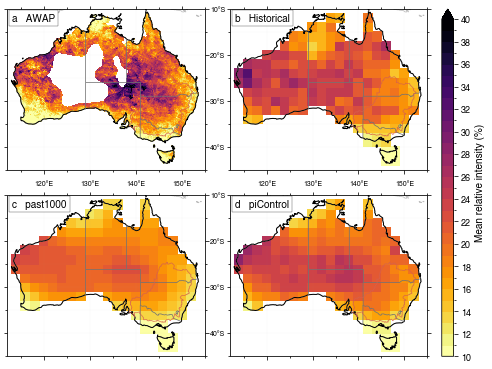

In [25]:
cpt = gmtColormap.gmtColormap('/Users/nickywright/Data/ColourPalettes/YlOrRd_09-1.cpt')
palette = LinearSegmentedColormap('my_colormap', cpt)

drought_type = 'droughts_2s2e_intensity_pc_mean'

lons = [awap_gf_annual.lon, hist_ens.lon, lm_ens.lon, cntl_ens_aus.lon]
lats = [awap_gf_annual.lat, hist_ens.lat, lm_ens.lat, cntl_ens_aus.lat]
data = [awap_gf_annual[drought_type], hist_ens[drought_type].mean(dim='model'),
        lm_ens[drought_type].mean(dim='model'), cntl_ens_aus[drought_type].mean(dim='model')]
# cmaps = [cmap]
colorbar_label = ['Mean relative intensity (%)']
contour_levels = np.arange(10, 41, 1)
cmaps = plt.cm.get_cmap('inferno_r')
# cmaps = palette
cbar_ticks = np.arange(10,42,2)
cbar_minor_ticks = np.arange(10,41,1)
 
norms = [BoundaryNorm(contour_levels, ncolors=cmaps.N, clip=False)]

label_fontsize=10
tick_fontsize = 9
annot_fontsize = 7
linewidth_border = 0.75
shrink=0.81  # for colorbar

subplot_title = ['a   AWAP', 'b   Historical', 'c   past1000', 'd   piControl']
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# --- start plotting
projection = ccrs.PlateCarree()

axes_class = (GeoAxes, dict(map_projection=projection))

# ------ actually plot
fig = plt.figure(figsize=(8,6.5))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(2, 2),
                axes_pad=(0.35, 0.35), # spacing between axes. horizontal, vertical
                label_mode='',
                cbar_location='right', cbar_mode='single',
                cbar_pad=0.2, cbar_size='3%')  # note the empty label_mode

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
for i, ax in enumerate(axgr):
   
    ax.set_extent([112, 155, -43, -10])
    ax.coastlines(color='#bdbdbd', linewidth=0.75)
    ax.gridlines(linewidth=0.1, alpha=0.3)
    
    
    if i == 0 or i == 2:
        for label in ax.get_yticklabels():
            label.set_visible(False)
            
    ax.set_xticks(np.arange(120, 160, 10), crs=projection)
    lon_formatter = LongitudeFormatter()
    ax.set_xticks(np.arange(115, 160, 5), minor=True)
    ax.xaxis.set_major_formatter(lon_formatter)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(annot_fontsize)
     
    #    --- set up y ticks
    ax.set_yticks(np.arange(-40, 0, 10), crs=projection)
    ax.set_yticks(np.arange(-45,-5,5), minor=True)
    lat_formatter = LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.yaxis.set_ticks_position('both')    
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(annot_fontsize)
    
    if i < 2:
        ax.xaxis.set_ticks_position('both')
        ax.tick_params(axis='x', pad=6.5)
        
            
    if i % 2 != 0:
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(annot_fontsize )
        ax.tick_params(axis='y', pad=1)
        ax.yaxis.set_ticks_position('both')

    if i >= 2:
        ax.xaxis.set_ticks_position('both')
        for label in ax.get_xticklabels():
            label.set_visible(False)
    
    ax.xaxis.set_tick_params(width=linewidth_border, which='both')
    ax.yaxis.set_tick_params(width=linewidth_border, which='both')
        
    
    # plot Aus as black outline
    shpfilename = shapereader.natural_earth(resolution='50m',
                                      category='cultural',
                                      name='admin_0_countries')
    
    reader = shapereader.Reader(shpfilename)
    countries = reader.records()

    for country in countries:
        if country.attributes['ADM0_A3'] == 'AUS':
            ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                          edgecolor='k', facecolor='none')
    
    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
    states_provinces = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines',
                                                    scale='50m', facecolor='none')
    ax.add_feature(states_provinces, edgecolor='#737373', linewidth=0.75)  # plot state lines
    ax.add_geometries(mdb.geometry, crs = ccrs.PlateCarree(), edgecolor='#d6604d', facecolor='none', linewidth=0.75, alpha=0.8)  # plot state lines
    
    # plot the data!
    p = ax.pcolormesh(lons[i], lats[i], data[i], 
                  transform=ccrs.PlateCarree(), cmap=cmaps, norm=norms[0],
                      vmin=contour_levels[0], vmax=contour_levels[-1])

#     if sig != None:
#         if i <= 13:
#             df_data_sig = data_sig[i].to_dataframe()
#             df_data_sig = df_data_sig.dropna()
#             df_data_sig = df_data_sig.reset_index()
#             p2 = ax.scatter(df_data_sig.lon, df_data_sig.lat, s=2, c='k', transform=ccrs.PlateCarree())    
    
    text_x = 0.025
    text_y = 0.91
    
    title = ax.text(text_x, text_y + 0.004, subplot_title[i], transform=ax.transAxes, 
                    horizontalalignment='left', verticalalignment='bottom', 
                    fontweight='normal', fontsize=label_fontsize, color='white',
                    bbox=dict(facecolor='white', edgecolor='black', linewidth=0.3, pad=3.0))
    
    title = ax.text(text_x, text_y, subplot_title[i], transform=ax.transAxes, 
                    horizontalalignment='left', verticalalignment='bottom', 
                    fontweight='normal', fontsize=label_fontsize)

    
cbar = plt.colorbar(p, cax=axgr.cbar_axes[0], extend='max', extendfrac=0.03, ticks=cbar_ticks)
cbar.set_label(colorbar_label[0], fontsize=10)
cbar.ax.tick_params(labelsize=tick_fontsize, length=4, width=linewidth_border)
# cbar.ax.minorticks_on()
cbar.ax.yaxis.set_ticks(cbar_minor_ticks, minor=True) 
cbar.ax.tick_params(width=linewidth_border, which='minor')
# cbar.set_ticks(cbar_minor_ticks, minor=True)    



fig.savefig('ens_%s.pdf' % drought_type, dpi=300, bbox_inches='tight')
plt.show()




### severity

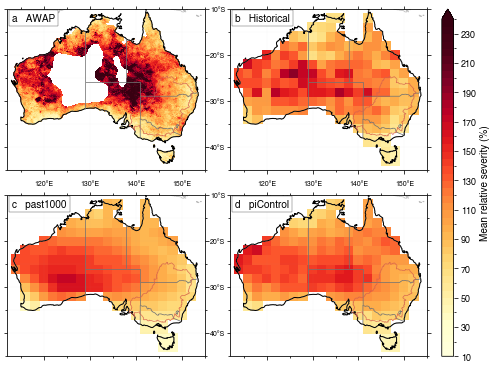

In [27]:
cpt = gmtColormap.gmtColormap('/Users/nickywright/Data/ColourPalettes/YlOrRd_09-1.cpt')
palette = LinearSegmentedColormap('my_colormap', cpt)

drought_type = 'droughts_2s2e_severity_pc_mean'

lons = [awap_gf_annual.lon, hist_ens.lon, lm_ens.lon, cntl_ens_aus.lon]
lats = [awap_gf_annual.lat, hist_ens.lat, lm_ens.lat, cntl_ens_aus.lat]
data = [awap_gf_annual[drought_type], hist_ens[drought_type].mean(dim='model'),
        lm_ens[drought_type].mean(dim='model'), cntl_ens_aus[drought_type].mean(dim='model')]
# cmaps = [cmap]
colorbar_label = ['Mean relative severity (%)']
contour_levels = np.arange(10, 245, 5)
# cmaps = plt.cm.get_cmap('Spectral_r')
cmaps = palette
cbar_ticks = np.arange(10,265,20)
cbar_minor_ticks = np.arange(10,250,10)
 
norms = [BoundaryNorm(contour_levels, ncolors=cmaps.N, clip=False)]

label_fontsize=10
tick_fontsize = 9
annot_fontsize = 7
linewidth_border = 0.75
shrink=0.81  # for colorbar

subplot_title = ['a   AWAP', 'b   Historical', 'c   past1000', 'd   piControl']
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# --- start plotting
projection = ccrs.PlateCarree()

axes_class = (GeoAxes, dict(map_projection=projection))

# ------ actually plot
fig = plt.figure(figsize=(8,6.5))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(2, 2),
                axes_pad=(0.35, 0.35), # spacing between axes. horizontal, vertical
                label_mode='',
                cbar_location='right', cbar_mode='single',
                cbar_pad=0.2, cbar_size='3%')  # note the empty label_mode

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
for i, ax in enumerate(axgr):
   
    ax.set_extent([112, 155, -43, -10])
    ax.coastlines(color='#bdbdbd', linewidth=0.75)
    ax.gridlines(linewidth=0.1, alpha=0.3)
    
    
    if i == 0 or i == 2:
        for label in ax.get_yticklabels():
            label.set_visible(False)
            
    ax.set_xticks(np.arange(120, 160, 10), crs=projection)
    lon_formatter = LongitudeFormatter()
    ax.set_xticks(np.arange(115, 160, 5), minor=True)
    ax.xaxis.set_major_formatter(lon_formatter)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(annot_fontsize)
     
    #    --- set up y ticks
    ax.set_yticks(np.arange(-40, 0, 10), crs=projection)
    ax.set_yticks(np.arange(-45,-5,5), minor=True)
    lat_formatter = LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.yaxis.set_ticks_position('both')    
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(annot_fontsize)
    
    if i < 2:
        ax.xaxis.set_ticks_position('both')
        ax.tick_params(axis='x', pad=6.5)
        
            
    if i % 2 != 0:
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(annot_fontsize)
        ax.tick_params(axis='y', pad=1)
        ax.yaxis.set_ticks_position('both')

    if i >= 2:
        ax.xaxis.set_ticks_position('both')
        for label in ax.get_xticklabels():
            label.set_visible(False)
    
    ax.xaxis.set_tick_params(width=linewidth_border, which='both')
    ax.yaxis.set_tick_params(width=linewidth_border, which='both')
        
    
    # plot Aus as black outline
    shpfilename = shapereader.natural_earth(resolution='50m',
                                      category='cultural',
                                      name='admin_0_countries')
    
    reader = shapereader.Reader(shpfilename)
    countries = reader.records()

    for country in countries:
        if country.attributes['ADM0_A3'] == 'AUS':
            ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                          edgecolor='k', facecolor='none')
    
    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
    states_provinces = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines',
                                                    scale='50m', facecolor='none')
    ax.add_feature(states_provinces, edgecolor='#737373', linewidth=0.75)  # plot state lines
    
    ax.add_geometries(mdb.geometry, crs = ccrs.PlateCarree(), edgecolor='#d6604d', facecolor='none', linewidth=0.75, alpha=0.8)  # plot state lines
    
    # plot the data!
    p = ax.pcolormesh(lons[i], lats[i], data[i], 
                  transform=ccrs.PlateCarree(), cmap=cmaps, norm=norms[0],
                      vmin=contour_levels[0], vmax=contour_levels[-1])

#     if sig != None:
#         if i <= 13:
#             df_data_sig = data_sig[i].to_dataframe()
#             df_data_sig = df_data_sig.dropna()
#             df_data_sig = df_data_sig.reset_index()
#             p2 = ax.scatter(df_data_sig.lon, df_data_sig.lat, s=2, c='k', transform=ccrs.PlateCarree())    
    
    text_x = 0.025
    text_y = 0.91
    
    title = ax.text(text_x, text_y + 0.004, subplot_title[i], transform=ax.transAxes, 
                    horizontalalignment='left', verticalalignment='bottom', 
                    fontweight='normal', fontsize=label_fontsize, color='white',
                    bbox=dict(facecolor='white', edgecolor='black', linewidth=0.3, pad=3.0))
    
    title = ax.text(text_x, text_y, subplot_title[i], transform=ax.transAxes, 
                    horizontalalignment='left', verticalalignment='bottom', 
                    fontweight='normal', fontsize=label_fontsize)

    
cbar = plt.colorbar(p, cax=axgr.cbar_axes[0], extend='max', extendfrac=0.03, ticks=cbar_ticks)
cbar.set_label(colorbar_label[0], fontsize=10)
cbar.ax.tick_params(labelsize=tick_fontsize, length=4, width=linewidth_border)
# cbar.ax.minorticks_on()
cbar.ax.yaxis.set_ticks(cbar_minor_ticks, minor=True) 
cbar.ax.tick_params(width=linewidth_border, which='minor')
# cbar.set_ticks(cbar_minor_ticks, minor=True)    



fig.savefig('ens_%s.pdf' % drought_type, dpi=300, bbox_inches='tight')
plt.show()





### intensity + severity

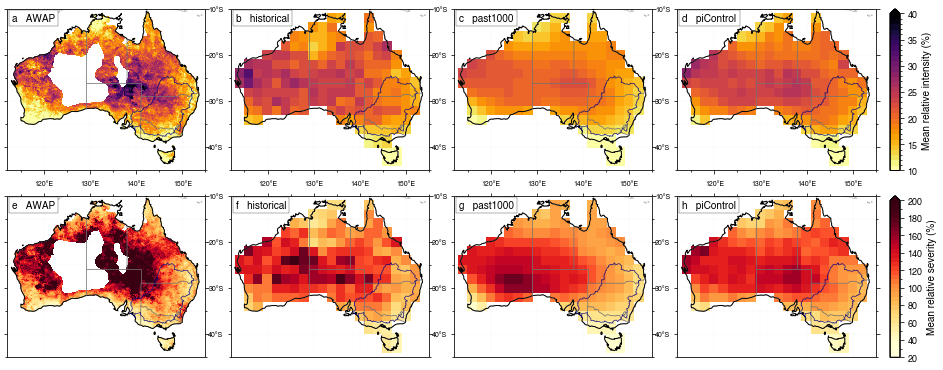

In [38]:
cpt = gmtColormap.gmtColormap('/Users/nickywright/Data/ColourPalettes/YlOrRd_09-1.cpt')
palette = LinearSegmentedColormap('my_colormap', cpt)

drought_type = 'droughts_2s2e_intensity_pc_mean'
drought_type2 = 'droughts_2s2e_severity_pc_mean'

lons = [awap_gf_annual.lon, hist_ens.lon, lm_ens.lon, cntl_ens_aus.lon, awap_gf_annual.lon, hist_ens.lon, lm_ens.lon, cntl_ens_aus.lon]
lats = [awap_gf_annual.lat, hist_ens.lat, lm_ens.lat, cntl_ens_aus.lat, awap_gf_annual.lat, hist_ens.lat, lm_ens.lat, cntl_ens_aus.lat]
data = [awap_gf_annual[drought_type], hist_ens[drought_type].mean(dim='model'),
        lm_ens[drought_type].mean(dim='model'), cntl_ens_aus[drought_type].mean(dim='model'),
        awap_gf_annual[drought_type2], hist_ens[drought_type2].mean(dim='model'),
        lm_ens[drought_type2].mean(dim='model'), cntl_ens_aus[drought_type2].mean(dim='model')]


# intensity
contour_levels1 = np.arange(10, 41, 1)
cmap1 = plt.cm.get_cmap('inferno_r')
# cmaps = palette
cbar_ticks1 = np.arange(10,45,5)
cbar_minor_ticks1 = np.arange(10,41,1)


# severity cmap
cpt = gmtColormap.gmtColormap('/Users/nickywright/Data/ColourPalettes/YlOrRd_09-1.cpt')
palette = LinearSegmentedColormap('my_colormap', cpt)


contour_levels2 = np.arange(20, 205, 5)
cbar_ticks2 = np.arange(20,220,20)
cbar_minor_ticks2 = np.arange(20,210,10)
cmap2 = palette

# ---
cmaps = [cmap1, cmap2]

contour_levels = [contour_levels1, contour_levels2]
norms = [BoundaryNorm(contour_levels1, ncolors=cmap1.N, clip=False), 
         BoundaryNorm(contour_levels2, ncolors=cmap2.N, clip=False)]

cbar_ticks = [cbar_ticks1, cbar_ticks2]
colorbar_label = ['Mean relative intensity (%)', 'Mean relative severity (%)']
cbar_minor_ticks = [cbar_minor_ticks1, cbar_minor_ticks2]

# ---
label_fontsize=10
tick_fontsize = 9
annot_fontsize = 7
linewidth_border = 0.75
shrink=0.81  # for colorbar

subplot_title = ['a   AWAP', 'b   historical', 'c   past1000', 'd   piControl',
                 'e   AWAP', 'f   historical', 'g   past1000', 'h   piControl']
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# --- start plotting
projection = ccrs.PlateCarree()

axes_class = (GeoAxes, dict(map_projection=projection))

# ------ actually plot
fig = plt.figure(figsize=(16,6.5))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(2, 4),
                axes_pad=(0.35, 0.35), # spacing between axes. horizontal, vertical
                label_mode='',
                cbar_location='right', cbar_mode='edge',
                cbar_pad=0.2, cbar_size='5%')  # note the empty label_mode

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
for i, ax in enumerate(axgr):
   
    ax.set_extent([112, 155, -43, -10])
    ax.coastlines(color='#bdbdbd', linewidth=0.75)
    ax.gridlines(linewidth=0.1, alpha=0.3)
    
    
            
    ax.set_xticks(np.arange(120, 160, 10), crs=projection)
    lon_formatter = LongitudeFormatter()
    ax.set_xticks(np.arange(115, 160, 5), minor=True)
    ax.xaxis.set_major_formatter(lon_formatter)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(annot_fontsize)
     
    #    --- set up y ticks
    ax.set_yticks(np.arange(-40, 0, 10), crs=projection)
    ax.set_yticks(np.arange(-45,-5,5), minor=True)
    lat_formatter = LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.yaxis.set_ticks_position('both')    
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(annot_fontsize)
    
    if i == 0 or i == 4:
        for label in ax.get_yticklabels():
            label.set_visible(False)
#         ax.yaxis.set_ticks_position('right')

    if i >= 4:
        ax.xaxis.set_ticks_position('both')
        ax.tick_params(axis='x', pad=6.5)
       
    if i <= 4:
        ax.tick_params(axis='x', pad=6.5)
            
#     if i % 4 != 0:
#         lat_formatter = LatitudeFormatter()
#         ax.yaxis.set_major_formatter(lat_formatter)
#         for tick in ax.yaxis.get_major_ticks():
#             tick.label.set_fontsize(annot_fontsize )
#         ax.tick_params(axis='y', pad=1)
#         ax.yaxis.set_ticks_position('both')

    if i >= 4:
        ax.xaxis.set_ticks_position('top')
        for label in ax.get_xticklabels():
            label.set_visible(False)
    
#     if i == 3 or i == 7:
#         ax.yaxis.set_ticks_position('left')
    
    ax.xaxis.set_tick_params(width=linewidth_border, which='both')
    ax.yaxis.set_tick_params(width=linewidth_border, which='both')
        
    
    # plot Aus as black outline
    shpfilename = shapereader.natural_earth(resolution='50m',
                                      category='cultural',
                                      name='admin_0_countries')
    
    reader = shapereader.Reader(shpfilename)
    countries = reader.records()

    for country in countries:
        if country.attributes['ADM0_A3'] == 'AUS':
            ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                          edgecolor='k', facecolor='none')
    
    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
    states_provinces = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines',
                                                    scale='50m', facecolor='none')
    ax.add_feature(states_provinces, edgecolor='#737373', linewidth=0.75)  # plot state lines
    ax.add_geometries(mdb.geometry, crs = ccrs.PlateCarree(), edgecolor='navy', facecolor='none', linewidth=0.75, alpha=0.8)  # plot state lines
    
    # plot the data!
    p = ax.pcolormesh(lons[i], lats[i], data[i], 
                  transform=ccrs.PlateCarree(), cmap=cmaps[i//4], norm=norms[i//4],
                      vmin=contour_levels[i//4][0], vmax=contour_levels[i//4][-1])

#     if sig != None:
#         if i <= 13:
#             df_data_sig = data_sig[i].to_dataframe()
#             df_data_sig = df_data_sig.dropna()
#             df_data_sig = df_data_sig.reset_index()
#             p2 = ax.scatter(df_data_sig.lon, df_data_sig.lat, s=2, c='k', transform=ccrs.PlateCarree())    
    
    text_x = 0.025
    text_y = 0.91
    
    title = ax.text(text_x, text_y + 0.004, subplot_title[i], transform=ax.transAxes, 
                    horizontalalignment='left', verticalalignment='bottom', 
                    fontweight='normal', fontsize=label_fontsize, color='white',
                    bbox=dict(facecolor='white', edgecolor='black', linewidth=0.3, pad=3.0))
    
    title = ax.text(text_x, text_y, subplot_title[i], transform=ax.transAxes, 
                    horizontalalignment='left', verticalalignment='bottom', 
                    fontweight='normal', fontsize=label_fontsize)


    if i % 4:
        cbar = plt.colorbar(p, cax=axgr.cbar_axes[i//4], extend='max', extendfrac=0.03, ticks=cbar_ticks[i//4])
        cbar.set_label(colorbar_label[i//4], fontsize=10)
        cbar.ax.tick_params(labelsize=tick_fontsize, length=4, width=0.75)
        # cbar.ax.minorticks_on()
        cbar.ax.yaxis.set_ticks(cbar_minor_ticks[i//4], minor=True) 
        cbar.ax.tick_params(width=linewidth_border, which='minor')
        # cbar.set_ticks(cbar_minor_ticks, minor=True)    



fig.savefig('ens_%s_%s.pdf' % (drought_type, drought_type2), dpi=300, bbox_inches='tight')
plt.show()





### no of events and sum

In [14]:
awap_gf_annual_droughts_2s2e_no_events_100yrs = xr.where(awap_gf_annual.droughts_2s2e_no_events_100yrs >= 0.000000001, awap_gf_annual.droughts_2s2e_no_events_100yrs, np.NaN)

In [15]:
awap_gf_annual_droughts_2s2e_sum_100yrs = xr.where(awap_gf_annual.droughts_2s2e_sum_100yrs >= 0.000000001, awap_gf_annual.droughts_2s2e_sum_100yrs, np.NaN)

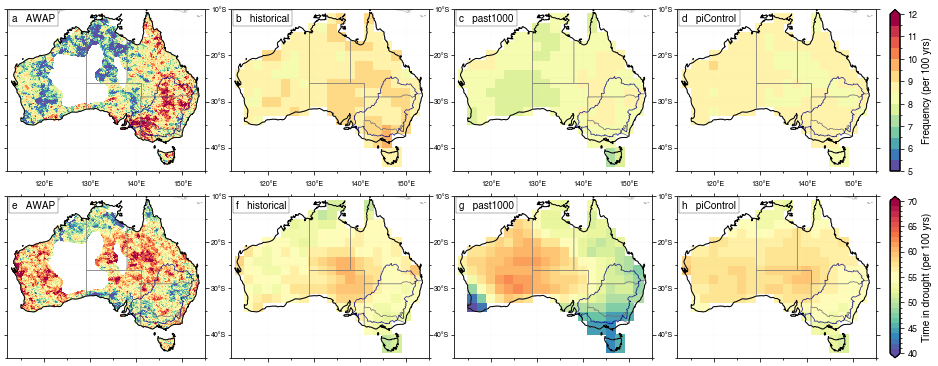

In [51]:
cpt = gmtColormap.gmtColormap('/Users/nickywright/Data/ColourPalettes/YlOrRd_09-1.cpt')
palette = LinearSegmentedColormap('my_colormap', cpt)

drought_type = 'droughts_2s2e_no_events_100yrs'
drought_type2 = 'droughts_2s2e_sum_100yrs'

lons = [awap_gf_annual_droughts_2s2e_no_events_100yrs.lon, hist_ens.lon, lm_ens.lon, cntl_ens_aus.lon, awap_gf_annual_droughts_2s2e_sum_100yrs.lon, hist_ens.lon, lm_ens.lon, cntl_ens_aus.lon]
lats = [awap_gf_annual_droughts_2s2e_no_events_100yrs.lat, hist_ens.lat, lm_ens.lat, cntl_ens_aus.lat, awap_gf_annual_droughts_2s2e_sum_100yrs.lat, hist_ens.lat, lm_ens.lat, cntl_ens_aus.lat]
data = [awap_gf_annual_droughts_2s2e_no_events_100yrs, hist_ens[drought_type].mean(dim='model'),
        lm_ens[drought_type].mean(dim='model'), cntl_ens_aus[drought_type].mean(dim='model'),
        awap_gf_annual_droughts_2s2e_sum_100yrs, hist_ens[drought_type2].mean(dim='model'),
        lm_ens[drought_type2].mean(dim='model'), cntl_ens_aus[drought_type2].mean(dim='model')]


# intensity
contour_levels1 = np.arange(5, 12.5, 0.5)
cmap1 = plt.cm.get_cmap('Spectral_r')
# cmaps = palette
cbar_ticks1 = np.arange(5,13,1)
cbar_minor_tick1 = np.arange(5,12.5,.5)


# severity cmap
# cpt = gmtColormap.gmtColormap('/Users/nickywright/Data/ColourPalettes/YlOrRd_09-1.cpt')
# palette = LinearSegmentedColormap('my_colormap', cpt)


contour_levels2 = np.arange(40, 71,1)
cbar_ticks2 = np.arange(40,75,5)
cmap2 = plt.cm.get_cmap('Spectral_r')
cbar_minor_tick2 = np.arange(40,71,1)
# ---
cmaps = [cmap1, cmap2]

contour_levels = [contour_levels1, contour_levels2]
norms = [BoundaryNorm(contour_levels1, ncolors=cmap1.N, clip=False), 
         BoundaryNorm(contour_levels2, ncolors=cmap2.N, clip=False)]

cbar_ticks = [cbar_ticks1, cbar_ticks2]
colorbar_label = ['Frequency (per 100 yrs)', 'Time in drought (per 100 yrs)']

cbar_extend = ['max', 'both']
cbar_minor_ticks = [cbar_minor_tick1, cbar_minor_tick2]

# ---
label_fontsize=10
tick_fontsize = 9
annot_fontsize = 7
linewidth_border = 0.75
shrink=0.81  # for colorbar

subplot_title = ['a   AWAP', 'b   historical', 'c   past1000', 'd   piControl',
                 'e   AWAP', 'f   historical', 'g   past1000', 'h   piControl']
# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
# --- start plotting
projection = ccrs.PlateCarree()

axes_class = (GeoAxes, dict(map_projection=projection))

# ------ actually plot
fig = plt.figure(figsize=(16,6.5))
axgr = AxesGrid(fig, 111, axes_class=axes_class,
                nrows_ncols=(2, 4),
                axes_pad=(0.35, 0.35), # spacing between axes. horizontal, vertical
                label_mode='',
                cbar_location='right', cbar_mode='edge',
                cbar_pad=0.2, cbar_size='5%')  # note the empty label_mode

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
for i, ax in enumerate(axgr):
   
    ax.set_extent([112, 155, -43, -10])
    ax.coastlines(color='#bdbdbd', linewidth=0.75)
    ax.gridlines(linewidth=0.1, alpha=0.3)
    
    
    if i == 0 or i == 4:
        for label in ax.get_yticklabels():
            label.set_visible(False)
            
    ax.set_xticks(np.arange(120, 160, 10), crs=projection)
    lon_formatter = LongitudeFormatter()
    ax.set_xticks(np.arange(115, 160, 5), minor=True)
    ax.xaxis.set_major_formatter(lon_formatter)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(annot_fontsize)
     
    #    --- set up y ticks
    ax.set_yticks(np.arange(-40, 0, 10), crs=projection)
    ax.set_yticks(np.arange(-45,-5,5), minor=True)
    lat_formatter = LatitudeFormatter()
    ax.yaxis.set_major_formatter(lat_formatter)
    ax.yaxis.set_ticks_position('both')    
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(annot_fontsize)
    
    if i >= 4:
        ax.xaxis.set_ticks_position('top')
        ax.tick_params(axis='x', pad=6.5)
    
    if i <= 4:
        ax.tick_params(axis='x', pad=6.5)
        
            
    if i % 4 != 0:
        lat_formatter = LatitudeFormatter()
        ax.yaxis.set_major_formatter(lat_formatter)
        for tick in ax.yaxis.get_major_ticks():
            tick.label.set_fontsize(annot_fontsize )
        ax.tick_params(axis='y', pad=1)
        ax.yaxis.set_ticks_position('both')

    if i >= 4:
        ax.xaxis.set_ticks_position('both')
        for label in ax.get_xticklabels():
            label.set_visible(False)
    
    ax.xaxis.set_tick_params(width=linewidth_border, which='both')
    ax.yaxis.set_tick_params(width=linewidth_border, which='both')
        
    
    # plot Aus as black outline
    shpfilename = shapereader.natural_earth(resolution='50m',
                                      category='cultural',
                                      name='admin_0_countries')
    
    reader = shapereader.Reader(shpfilename)
    countries = reader.records()

    for country in countries:
        if country.attributes['ADM0_A3'] == 'AUS':
            ax.add_geometries(country.geometry, ccrs.PlateCarree(),
                          edgecolor='k', facecolor='none')
    
    # Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
    states_provinces = cfeature.NaturalEarthFeature(category='cultural', name='admin_1_states_provinces_lines',
                                                    scale='50m', facecolor='none')
    ax.add_feature(states_provinces, edgecolor='#737373', linewidth=0.75)  # plot state lines
    ax.add_geometries(mdb.geometry, crs = ccrs.PlateCarree(), edgecolor='navy', facecolor='none', linewidth=0.75, alpha=0.8)  # plot state lines
    
    # plot the data!
    p = ax.pcolormesh(lons[i], lats[i], data[i], 
                  transform=ccrs.PlateCarree(), cmap=cmaps[i//4], norm=norms[i//4],
                      vmin=contour_levels[i//4][0], vmax=contour_levels[i//4][-1])

#     if sig != None:
#         if i <= 13:
#             df_data_sig = data_sig[i].to_dataframe()
#             df_data_sig = df_data_sig.dropna()
#             df_data_sig = df_data_sig.reset_index()
#             p2 = ax.scatter(df_data_sig.lon, df_data_sig.lat, s=2, c='k', transform=ccrs.PlateCarree())    
    
    text_x = 0.025
    text_y = 0.91
    
    title = ax.text(text_x, text_y + 0.004, subplot_title[i], transform=ax.transAxes, 
                    horizontalalignment='left', verticalalignment='bottom', 
                    fontweight='normal', fontsize=label_fontsize, color='white',
                    bbox=dict(facecolor='white', edgecolor='black', linewidth=0.3, pad=3.0))
    
    title = ax.text(text_x, text_y, subplot_title[i], transform=ax.transAxes, 
                    horizontalalignment='left', verticalalignment='bottom', 
                    fontweight='normal', fontsize=label_fontsize)


    if i % 4:
        cbar = plt.colorbar(p, cax=axgr.cbar_axes[i//4], extend=cbar_extend[i//4], extendfrac=0.03, ticks=cbar_ticks[i//4])
        cbar.set_label(colorbar_label[i//4], fontsize=10)
        cbar.ax.tick_params(labelsize=tick_fontsize, length=4, width=0.75)
        # cbar.ax.minorticks_on()
        cbar.ax.yaxis.set_ticks(cbar_minor_ticks[i//4], minor=True) 
        cbar.ax.tick_params(width=linewidth_border, which='minor')
        # cbar.set_ticks(cbar_minor_ticks, minor=True)    



fig.savefig('ens_%s_%s.pdf' % (drought_type, drought_type2), dpi=300, bbox_inches='tight')
plt.show()




